<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/experiment_100_gmm_prob_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

Mounted at /content/gdrive
/content/gdrive/MyDrive/concept_learning/concept_learning


In [3]:
!pwd

/content/gdrive/MyDrive/concept_learning/concept_learning


In [ ]:
# !git checkout .
!git pull

Already up to date.


In [ ]:
!git diff clearn/analysis/cluster_utils.py


In [4]:
env = "colab"

In [5]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model, get_train_val_iterator,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_next_level_gmm, cluster_and_decode_latent_vectors_gmm
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from PIL import Image


%matplotlib inline


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

# Set experiment parameters

In [7]:
z_dim = 10
run_id = 3
num_units=[64, 128, 32]
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW
experiment_name = "experiment_100_gmm_prob"
base_path = "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3"


In [8]:
clean_up_previous_run = False
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"
    # if clean_up_previous_run :
    #     rm -rf 
!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3

In [9]:
experiment_name = "experiment_100_gmm_prob"
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=num_units,
                              num_cluster_config=num_cluster_config,
                              confidence_decay_factor=run_id,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval_in_epochs=1,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID",
                              learning_rate = 1e-3
                              )
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST


In [10]:
K = exp_config.confidence_decay_factor
def convert_distance_to_confidence_exp(dist):
    return np.exp(-1 / K * dist)

def get_distance_exp(confidence):
    return -K * log(confidence)

def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))


In [11]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [13]:
num_epochs = 2
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                                                                     root_path=root_path,
                                                                                     z_dim=z_dim,
                                                                                     run_id=run_id,
                                                                                     create_split=create_split,
                                                                                     num_epochs=num_epochs,
                                                                                     num_epochs_completed=0,
                                                                                     num_cluster_config=num_cluster_config,
                                                                                     model_type=model_type
                                                                                    )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100_gmm_prob'}
Warning /content/gdrive/MyDrive/

In [14]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/analysis/manual_annotation.csv path does not exist. Creating random prior with uniform distribution
Total Manual annotation confidence 0.0


# Load the trained model

In [15]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=model_type,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.mode

# Read the latent vectors for train data

In [16]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=3 z_min=-4.46163 z_max=4.659187
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [17]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 2.0


# Use Elbow method to to find out number of optimum clusters k

In [18]:
# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [19]:
# if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
#     num_clusters = visualizer.elbow_value_
# else:
#     num_clusters = 2 * visualizer.elbow_value_
# if num_clusters < 10:
#     num_clusters = 10
# print(f"Number of clusters {num_clusters}")
num_clusters=10

In [20]:
# from sklearn.mixture import GaussianMixture
# from clearn.dao.idao import IDao

# def decode_latent_vectors(model_type: str,
#                           cluster_centers: np.ndarray,
#                           exp_config: ExperimentConfig,
#                           dao: IDao):
#     with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
#         model = get_model(dao, exp_config, model_type, num_epochs=0, sess=sess)
#         z = np.zeros([cluster_centers.shape[0], exp_config.Z_DIM])
#         for i in range(cluster_centers.shape[0]):
#             z[i, :] = cluster_centers[i]
#         decoded_images = decode(model, z, exp_config.BATCH_SIZE)
#         return decoded_images

    
# def cluster_and_decode_latent_vectors_gmm(model_type: str,
#                                           num_clusters: int,
#                                           latent_vectors: np.ndarray,
#                                           exp_config: ExperimentConfig,
#                                           dao: IDao):
#     gm = GaussianMixture(n_components=num_clusters, random_state=0)
#     cluster_labels = gm.fit_predict(latent_vectors)
#     cluster_centers = gm.means_
#     decoded_images = decode_latent_vectors(model_type, cluster_centers, exp_config, dao)
#     posterior = gm.predict_proba(latent_vectors)

#     return decoded_images, cluster_centers, cluster_labels, posterior


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.mode

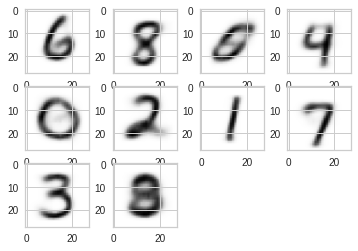

In [21]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if  not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])
    posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])   
   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [22]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [6, 8, -1, -1,
                                               0, 2, 1, 7,
                                               3, -1
                                              ]
    manual_annotation_json["manual_confidence"] = [1, 1, 0, 0,
                                                   0.7, 0.8, 1, 0.8,
                                                   0.9, 0
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    manual_annotation_json["posterior_proba"] = posterior_proba.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [23]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [24]:
cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [25]:
cluster_group_dict

{None: <clearn.analysis.ClusterGroup at 0x7fe40ca00d10>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7fe4149c65d0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fe4149c6610>}

In [26]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


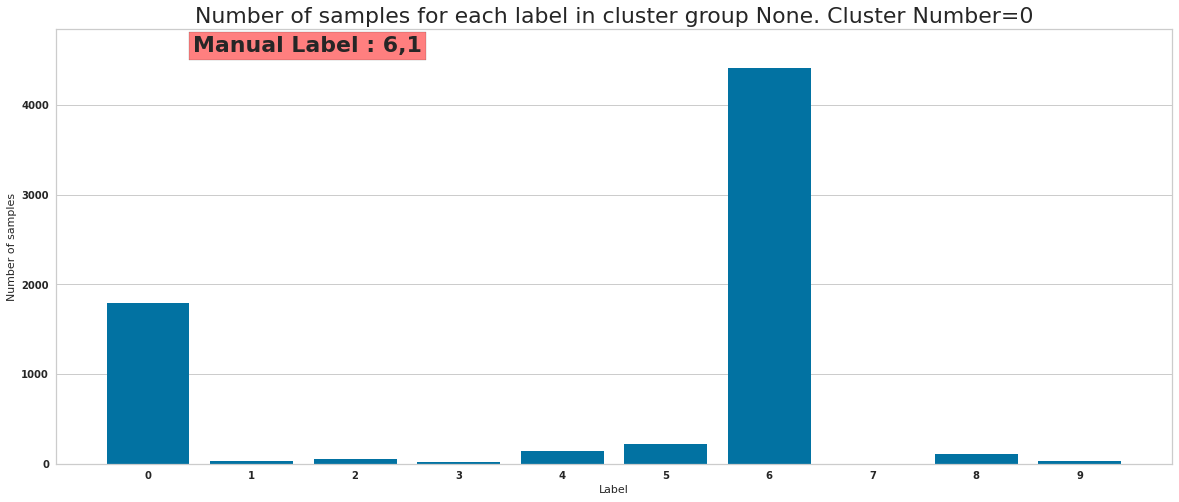

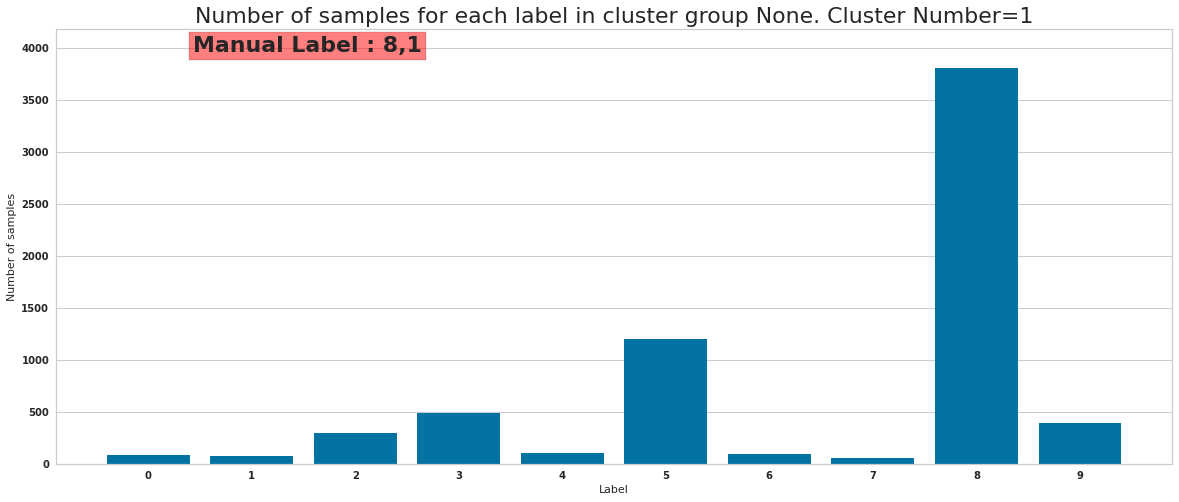

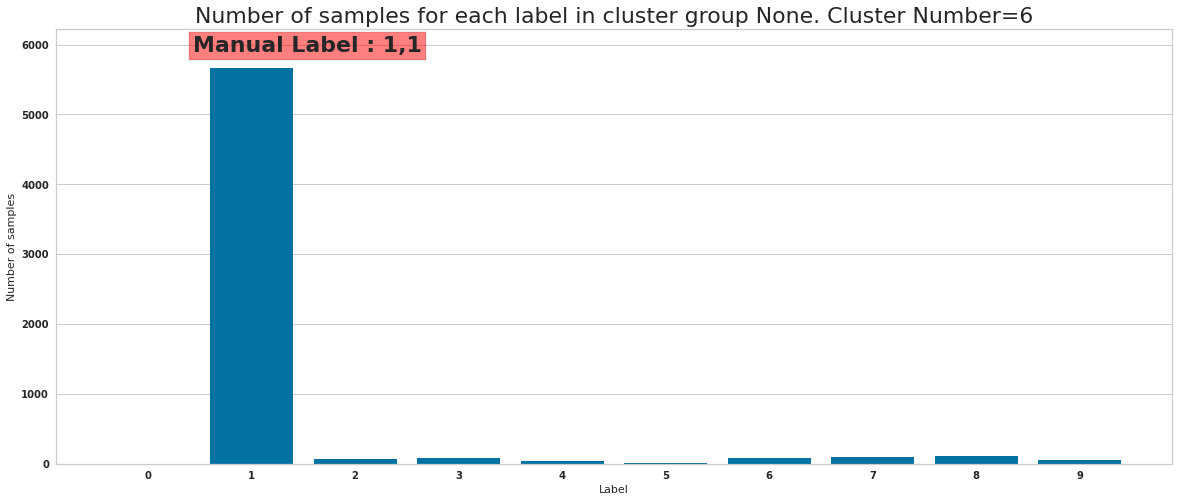

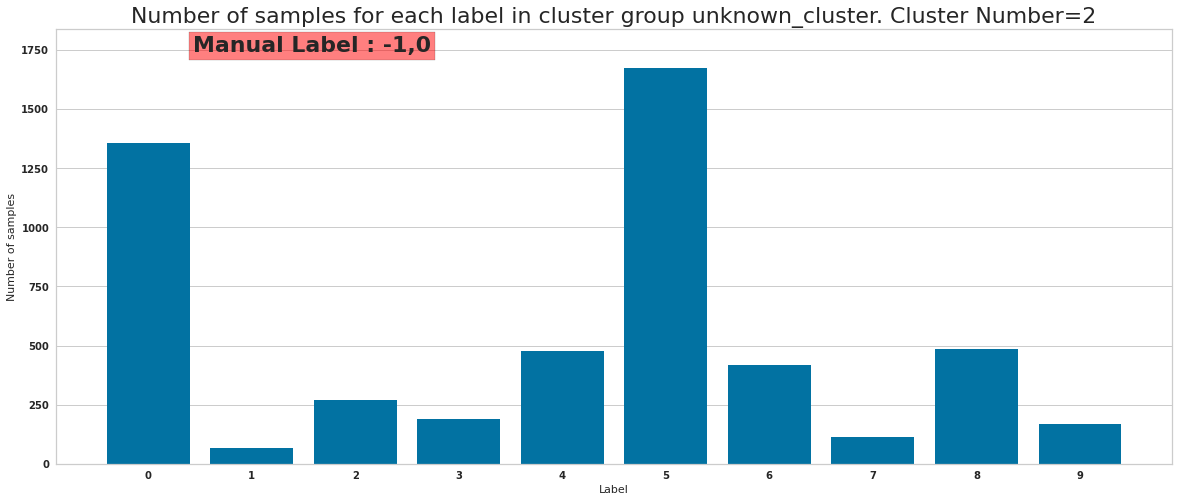

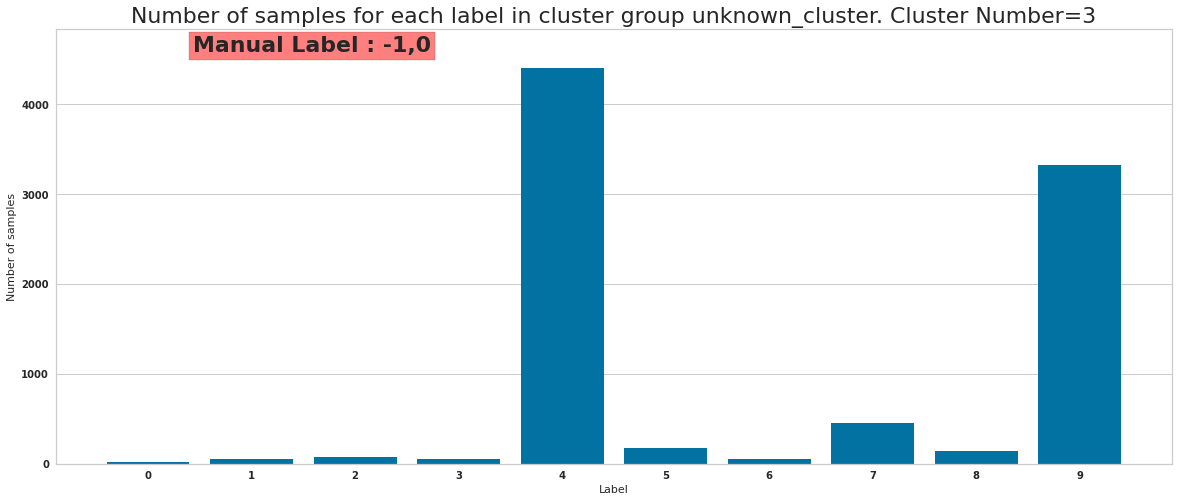

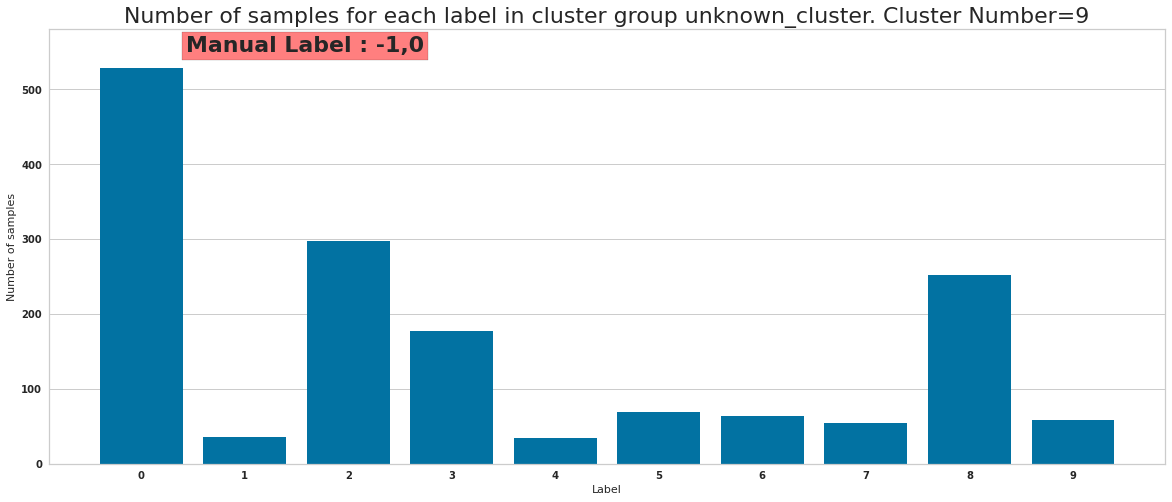

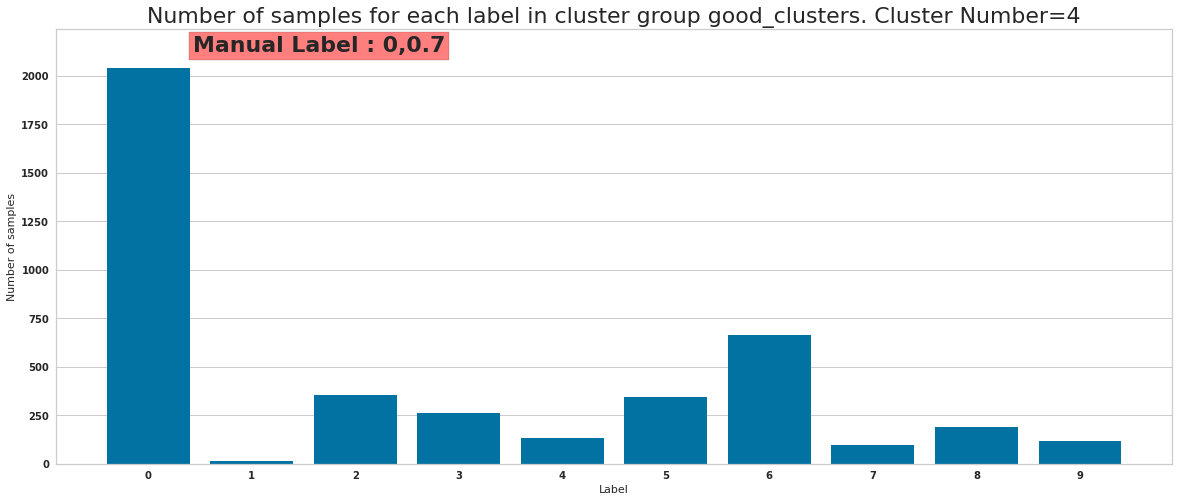

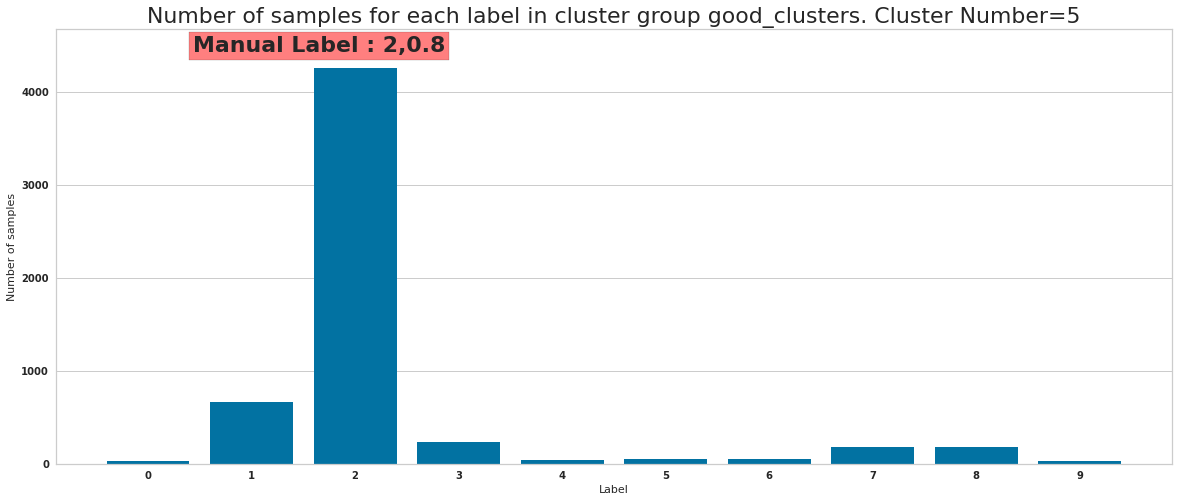

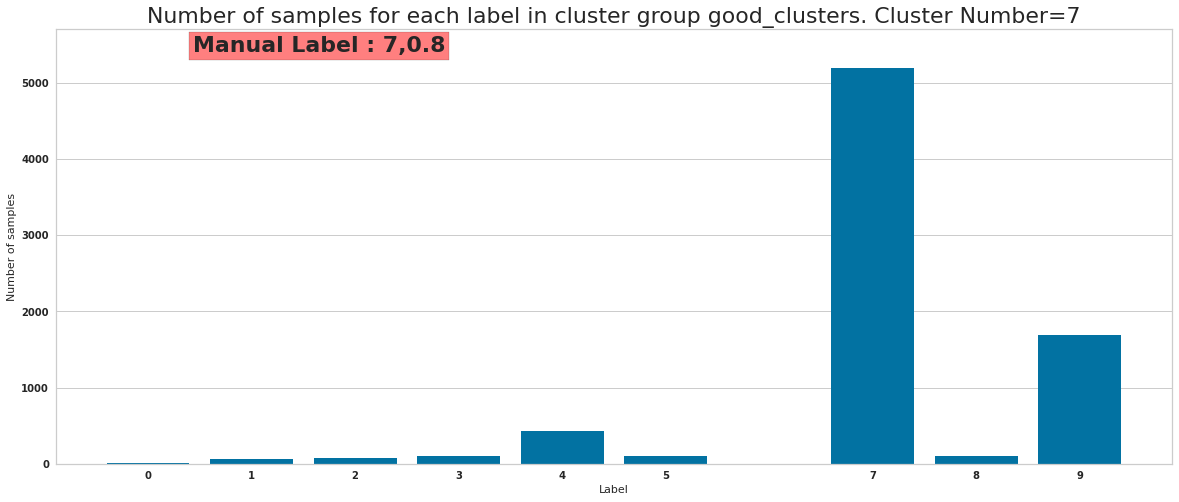

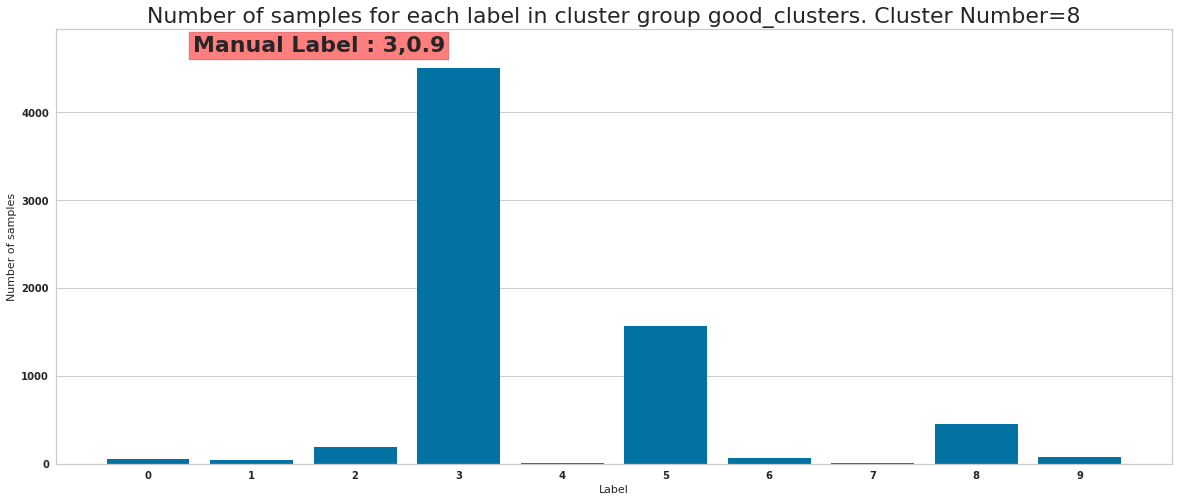

In [27]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [28]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(6814, 10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(6588, 10)
(5221, 10)
(8745, 10)
(4225, 10)
(5709, 10)
(6240, 10)
(7759, 10)
(6967, 10)
(1572, 10)


In [29]:
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

Posterior probability shape (59840, 10)


In [30]:
df.head()

label  label_predicted      mu_0  ...  confidence_7  confidence_8  confidence_9
0      4                9  0.286178  ...  9.055747e-02  8.183446e-12       0.00007
1      3                7  1.135956  ...  9.323630e-03  4.125603e-02       0.00257
2      1                2 -0.031638  ...  1.310244e-02  3.545343e-08       0.01643
3      2                0  0.730745  ...  4.524958e-05  4.934871e-01       0.25648
4      2                0  2.073029  ...  4.452135e-07  3.186033e-06       0.00054

[5 rows x 53 columns]

In [31]:
def validate_tokenize_int(lbl, length):
  print(f"Parsing manual entry {lbl}")
  lbls = lbl.split(",")
  if len(lbls) != length :
    raise Exception(f"Enter a text with {length} comma separated integers in the range of [0,9] or -1. -1 for unknown label")
  return [int(l) for l in lbls]

def validate_tokenize_float(lbl, length):
  print(f"Parsing manual entry {lbl}")
  lbls = lbl.split(",")
  if len(lbls) != length :
    raise Exception(f"Enter a text with {length} comma separated integers in the range of [0,9] or -1. -1 for unknown label")
  return [float(l) for l in lbls]

2
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.mo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

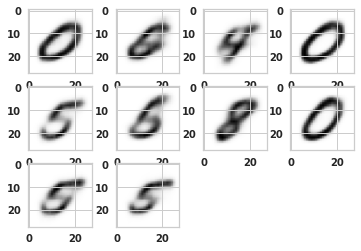

3
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.mo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

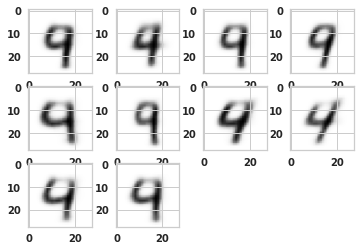

9
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.mo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

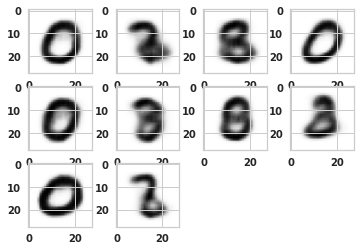

In [34]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [ ]:
# class_labels = widgets.Text(place_holder="-1,-1,-1,-1,-1,-1,-1,-1,-1,-1",
#     description="Labels")
# display(class_labels)

In [ ]:
# validate_tokenize(class_labels.value, 10)

In [ ]:
[k for k in level2_manual_annotations.keys()]

[2, 4, 6]

In [ ]:
# from ipywidgets import widgets
# btb = widgets.BoundedIntText(
#  value=7,
#  min=0,
#  max=10
#  )
# display(btb)

BoundedIntText(value=7, max=10)

In [ ]:
# class_labels = widgets.Text(place_holder="-1-1-1-1",
#                             description="Labels")

In [ ]:
# display(class_labels)

Text(value='', description='Labels')

In [ ]:
# labels_1 = validate_tokenize(class_labels.value, 4)

In [ ]:
# labels_1

[-1, -1, -1, -1]

In [36]:
level_2_cluster_dict = level2_manual_annotations[2]
level_2_cluster_dict["manual_labels"] = [
                                         0, -1, -1, 0,
                                         -1, -1, -1, 0,
                                         -1, -1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.7, 0, 0, 1,
                                              0, 0, 0, 1,
                                              0, 0
                                              ]

level_2_cluster_dict = level2_manual_annotations[3]
level_2_cluster_dict["manual_labels"] = [9, -1, 9, 9,
                                         -1,9,-1,4,
                                         -1, -1]

level_2_cluster_dict["manual_confidences"] = [0.8,0,0.8,0.8,
                                              0, 0.8,0,0.8,
                                              0, 0
                                             ]


level_2_cluster_dict = level2_manual_annotations[9]
level_2_cluster_dict["manual_labels"] = [0, -1, -1, 0,
                                        0, -1, -1, -1,
                                        0, -1
                                         ]
level_2_cluster_dict["manual_confidences"] = [0.8, 0, 0, 1,
                                              0.7, 0, 0, 0,
                                              1, 0
                                             ]


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [9, -1,-1,-1,
#                                         9,-1,-1,9,
#                                         9,-1]

# level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0.7,
#                                               0.7,0.7,0.7,0.7,
#                                               0.7,0.7
#                                              ]

# level2_manual_annotations[7] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1,-1,-1,
#                                         -1,-1,0,-1,
#                                         -1,0]

# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0.9,0,
#                                               0,0.9
#                                              ]

# level2_manual_annotations[7] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [8,8,3,8,
#                                         3,3,8,-1,
#                                         -1,-1]

# level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.7,0.8,
#                                               0.7, 0.7, 0.8, 0,
#                                               0,0
#                                              ]

# level2_manual_annotations[8] = level_2_cluster_dict


level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)


In [37]:
print("Setting  next_level_clusters attribute to each primary cluster")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

print("Computing distances from second level cluster centers")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)

    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster, cluster_column_name_2)

Setting  next_level_clusters attribute to each primary cluster
2
3
9
Computing distances from second level cluster centers
2
10
0 (244,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Skipping distance computation for unknown cluster
3 (629,)
7 (407,)
3
10
0 (689,)
2 (683,)
3 (1102,)
5 (1069,)
7 (1195,)
Skipping distance computation for unknown cluster
9
10
0 (94,)
4 (197,)
Skipping distance computation for unknown cluster
3 (134,)
8 (168,)


In [38]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [39]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [40]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [42]:
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Manual Label 6
(6814, 117) (6814, 33)
Num correct=4405
Cluster 0 Manual Label 6 Percentage correct 64.64631640739654
********************************
Manual Label 8
(6588, 117) (6588, 33)
Num correct=3799
Cluster 1 Manual Label 8 Percentage correct 57.66545233758349
********************************
unknown
<class 'dict'>
['good_clusters', 'unknown_cluster', None]
2
Second level cluster id 0
********0*******
Manual_label 0
Second level cluster id 1
********-1*******
Annotating individual samples (449,)
Second level cluster id 2
********-1*******
Annotating individual samples (803,)
Second level cluster id 4
********-1*******
Annotating individual samples (617,)
Second level cluster id 5
********-1*******
Annotating individual samples (658,)
Second level cluster id 6
********-1*******
Annotating individual samples (516,)
Second level cluster id 8
********-1*******
Annotating individual samples (295,)
Second level cluster id 9
********-1*******
Annotating individual samples (603,)
Second 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [43]:
num_individual_samples_annotated

8927

# Save the dataframe with manual annotations

In [44]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([6814., 6588., 5221., 8745., 4225., 5709., 6240., 7759., 6967.,
        1572.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

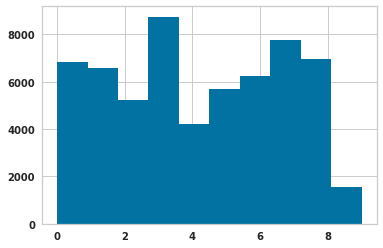

In [45]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [46]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


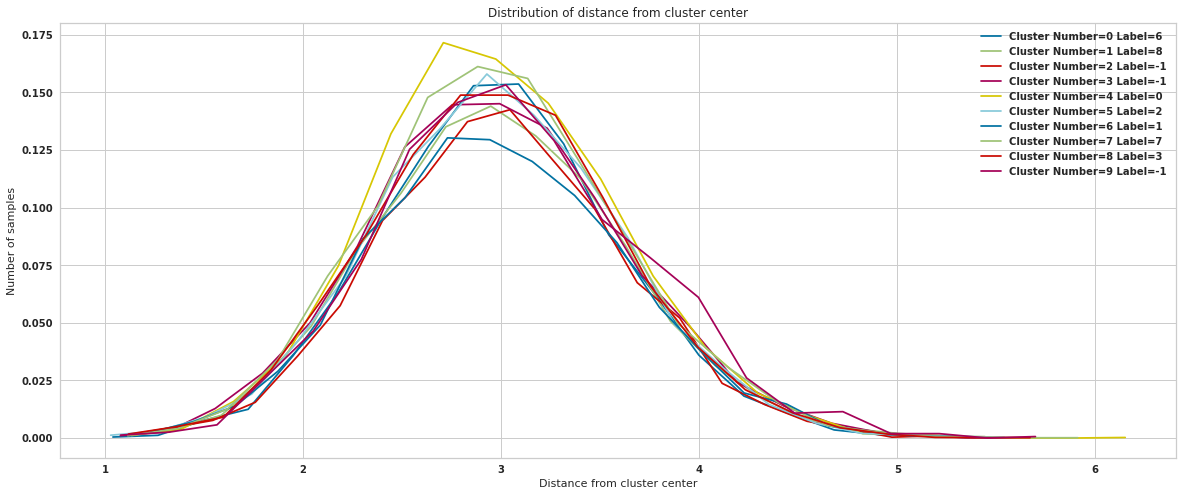

In [47]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

In [48]:
def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1

In [49]:
df1 = df[df["manual_annotation_confidence"] > 0.1]
print(df1.shape)


(59840, 117)


In [50]:
df.columns
cols = [f"confidence_{i}" for i in range(num_clusters)]
cols.append("manual_annotation_confidence")

In [51]:
df[ (df["manual_annotation"] == 6) & (df["cluster_level_1"] == 0)][cols].head()


confidence_0  confidence_1  ...  confidence_9  manual_annotation_confidence
24      0.802077      0.000002  ...      0.001692                      0.802077
28      0.862764      0.003224  ...      0.105943                      0.862764
31      0.926602      0.006680  ...      0.000353                      0.926602
40      0.896298      0.000083  ...      0.000527                      0.896298
43      0.462967      0.002552  ...      0.008373                      0.462967

[5 rows x 11 columns]

In [52]:
df["manual_annotation_confidence"].describe()

count    59840.000000
mean         0.753704
std          0.210481
min          0.150440
25%          0.594296
50%          0.786454
75%          0.970970
max          1.000000
Name: manual_annotation_confidence, dtype: float64

Text(0, 0.5, 'Percentage Correct')

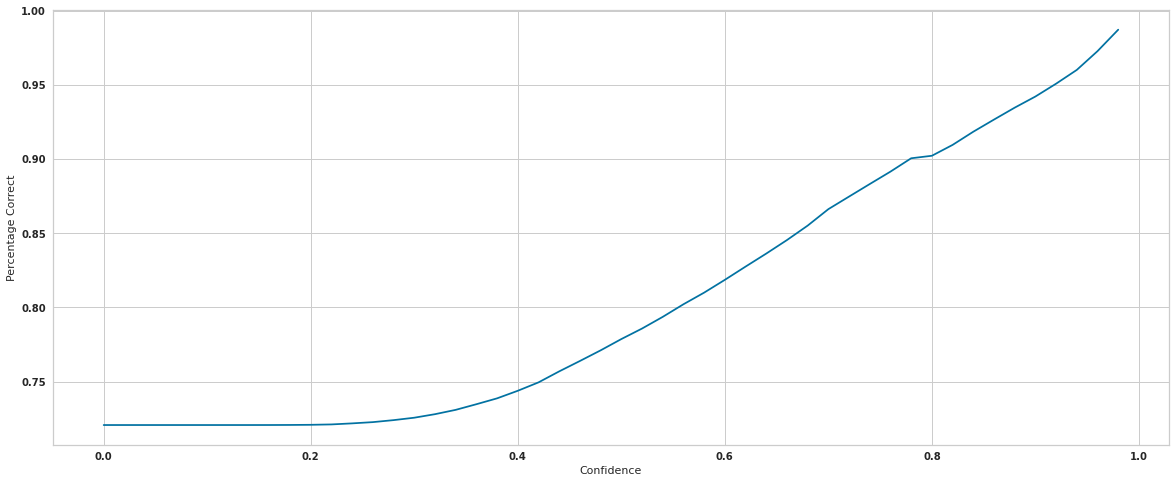

In [53]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

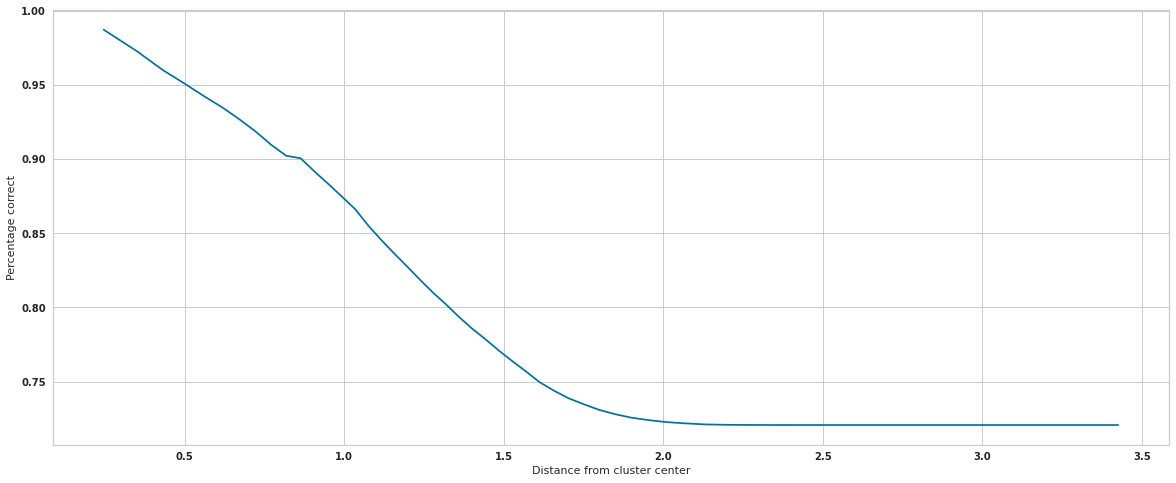

In [54]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [55]:
from shutil import copy2

In [56]:
num_epochs = 2

In [57]:
epochs_completed

2.0

In [58]:
from typing import List

def get_manual_annotation_col_name(epochs_completed):
    epoch_col_confidence = f"manual_confidence_{int(epochs_completed)}"
    epoch_col_label = f"manual_label_{int(epochs_completed)}"
    return epoch_col_confidence, epoch_col_label

def get_overall_confidence(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_confidence]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        if max(confidences) == 1:
            return 1
        else:
            return confidences[-1]


def get_overall_label(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_label]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        labels = [row[get_manual_annotation_col_name(epoch)[1]] for epoch in epochs_competed]

        # argmax of confidences
        max_index = max(enumerate(confidences), key=lambda x: x[1])[0]
        if confidences[max_index] == 1:
            return labels[max_index]
        else:
            return labels[-1]


In [59]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

No existing manual annotation file. Creating new manual annotation dataframe
manual_label_0
manual_label_1
manual_label_2


In [60]:
manual_annotation_df.shape

(59840, 4)

In [61]:
manual_annotation_df.head()

manual_label_2  ...  manual_annotation_confidence
0             4.0  ...                      0.426001
1             3.0  ...                      1.000000
2             1.0  ...                      0.964715
3             3.0  ...                      0.444138
4             2.0  ...                      0.796213

[5 rows x 4 columns]

In [62]:
df.head()

label  label_predicted  ...  manual_annotation_confidence  distance_to_confidence
0      4                9  ...                      0.426001                     0.0
1      3                7  ...                      1.000000                     0.0
2      1                2  ...                      0.964715                     0.0
3      2                0  ...                      0.444138                     0.0
4      2                0  ...                      0.796213                     0.0

[5 rows x 117 columns]

In [63]:
#cols.append("cluster_level_2")
cols.append("manual_annotation")
df[cols].head()

confidence_0  confidence_1  ...  manual_annotation_confidence  manual_annotation
0  1.245473e-06      0.000686  ...                      0.426001                4.0
1  2.240844e-07      0.070112  ...                      1.000000                3.0
2  3.636857e-09      0.000237  ...                      0.964715                1.0
3  1.049022e-05      0.002439  ...                      0.444138                3.0
4  1.065899e-07      0.000003  ...                      0.796213                2.0

[5 rows x 12 columns]

In [67]:
second_level_cols = [f"confidence_level_{2}_{9}_{i}"  for i in range(10)]

In [68]:
df[second_level_cols].head()

confidence_level_2_9_0  ...  confidence_level_2_9_9
0                     0.0  ...                     0.0
1                     0.0  ...                     0.0
2                     0.0  ...                     0.0
3                     0.0  ...                     0.0
4                     0.0  ...                     0.0

[5 rows x 10 columns]

In [69]:
manual_labels

[6, 8, -1, -1, 0, 2, 1, 7, 3, -1]

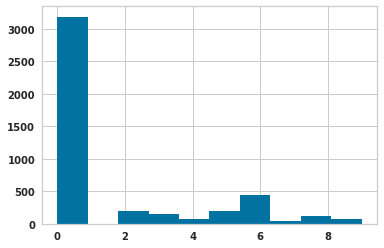

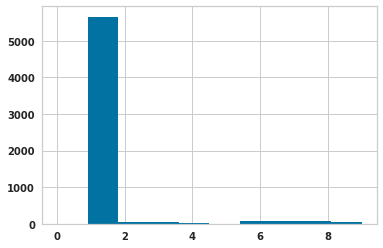

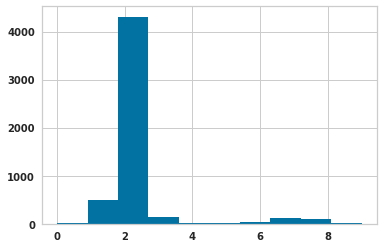

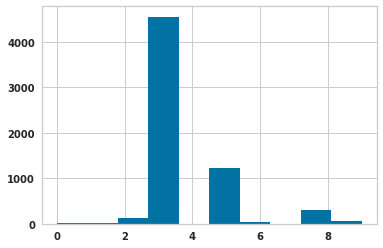

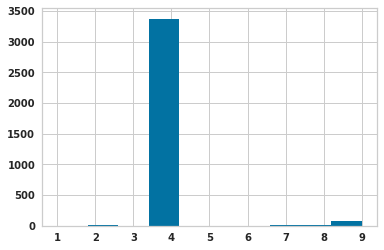

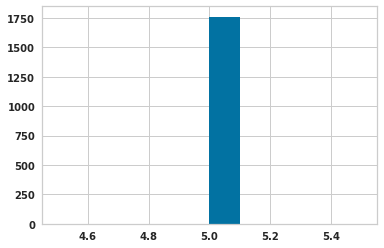

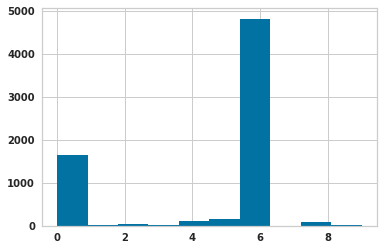

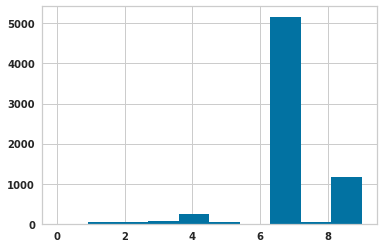

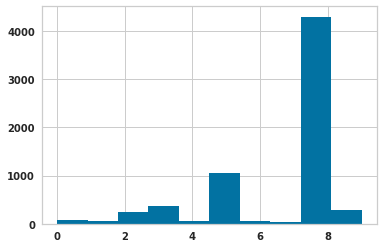

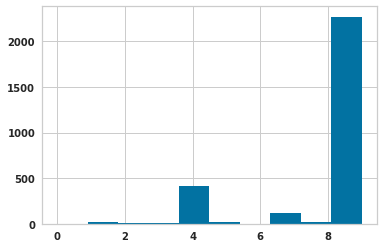

In [70]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 2

In [71]:
num_epochs

2

In [72]:
def get_num_samples_wrongly_annotated():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2.shape[0]
    else:
        return 0


In [73]:
def get_sum_confidence_wrong():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2["manual_annotation_confidence"].sum()
    else:
        return 0


In [84]:
    df1 = df[df["manual_annotation_confidence"] > 0]
    print("Rows with manual annotation confidence greater than zero", df1.shape)
    df2 = df1[df1["manual_annotation"] != df1["label"]]
    print("Number of rows wrongly annotated samples", df2.shape)
    df1[df1["manual_annotation"] == df1["label"]].shape
    df2["manual_annotation_confidence"].sum()


Rows with manual annotation confidence greater than zero (59840, 117)
Number of rows wrongly annotated samples (16715, 117)


10036.743584050428

# Get the number of samples annotated

In [74]:
epochs_completed

2.0

In [75]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

epoch  train_accuracy  ...  val_reconstruction_loss  test_reconstruction_loss
0      2        0.137901  ...               128.802368                 126.60717

[1 rows x 7 columns]

In [76]:
num_individual_samples_annotated

8927

In [77]:
num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()

epoch  ...  total_confidence_of_wrong_annotation
0      2  ...                          10036.743584

[1 rows x 10 columns]

In [85]:
confidence

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [86]:
percentage_correct

array([0.72067179, 0.72067179, 0.72067179, 0.72067179, 0.72067179,
       0.72067179, 0.72067179, 0.72067179, 0.72068383, 0.72072735,
       0.72082797, 0.72108399, 0.721789  , 0.72263338, 0.72397839,
       0.72561338, 0.72798782, 0.7309079 , 0.73470741, 0.73867251,
       0.74377882, 0.74943933, 0.75685765, 0.76387048, 0.77104312,
       0.77865417, 0.78575332, 0.79362973, 0.80212834, 0.8099834 ,
       0.81860841, 0.8275368 , 0.83632463, 0.845444  , 0.85519273,
       0.86629706, 0.87479085, 0.88324638, 0.89162202, 0.90062656,
       0.90231756, 0.90964002, 0.91853601, 0.92672776, 0.93476932,
       0.94227867, 0.95093764, 0.96023777, 0.97289345, 0.98736449])

In [88]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name, index=False)

In [89]:
metric_df.to_csv(metric_file, index=False)

# Start training for one more epoch

In [90]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        learning_rate=5e-4,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0005, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100_gmm_prob'}
Loaded manual annotation
Number

In [91]:
num_epochs

3

In [92]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.mode

In [93]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=3 z_min=-5.108325 z_max=4.975225
Latent vectors shape (59840, 10)


In [94]:
# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [95]:
# if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
#     num_clusters = visualizer.elbow_value_
# else:
#     num_clusters = 2 * visualizer.elbow_value_
# if num_clusters < 10:
#     num_clusters = 10
num_clusters = 10
print(f"Number of clusters {num_clusters}")

Number of clusters 10


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.mode

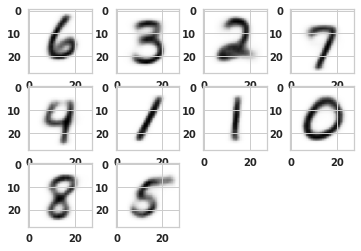

In [97]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if  not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])
    posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])   
   
    img = Image.open(image_filename)
    img.show()
    

In [103]:
import json
# TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6,3,2,7,
                                           -1,1,1,0,
                                           8,-1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.8, 1, 1,
                                               0, 1, 1, 1,
                                               0.9, 0
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [104]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [105]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

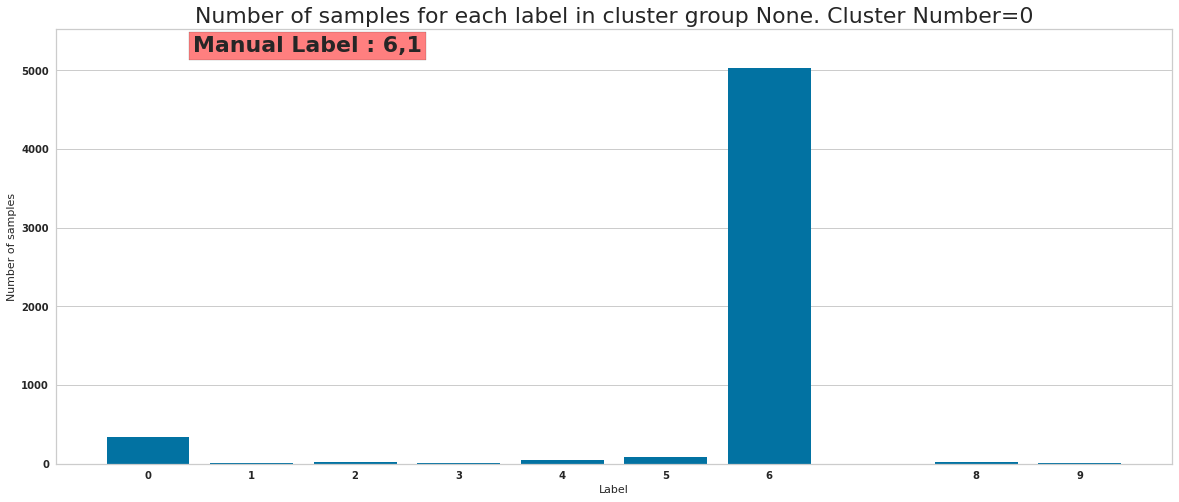

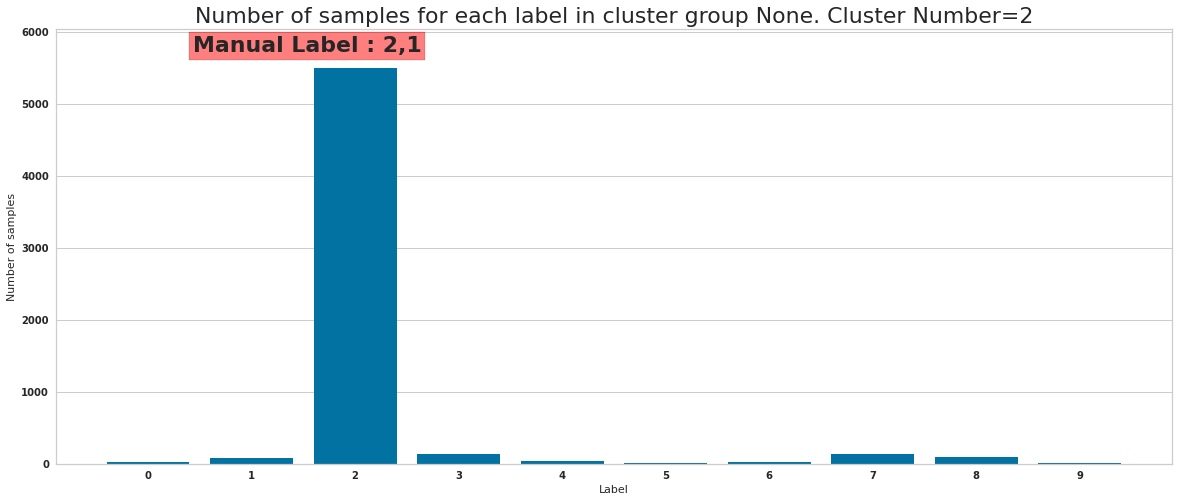

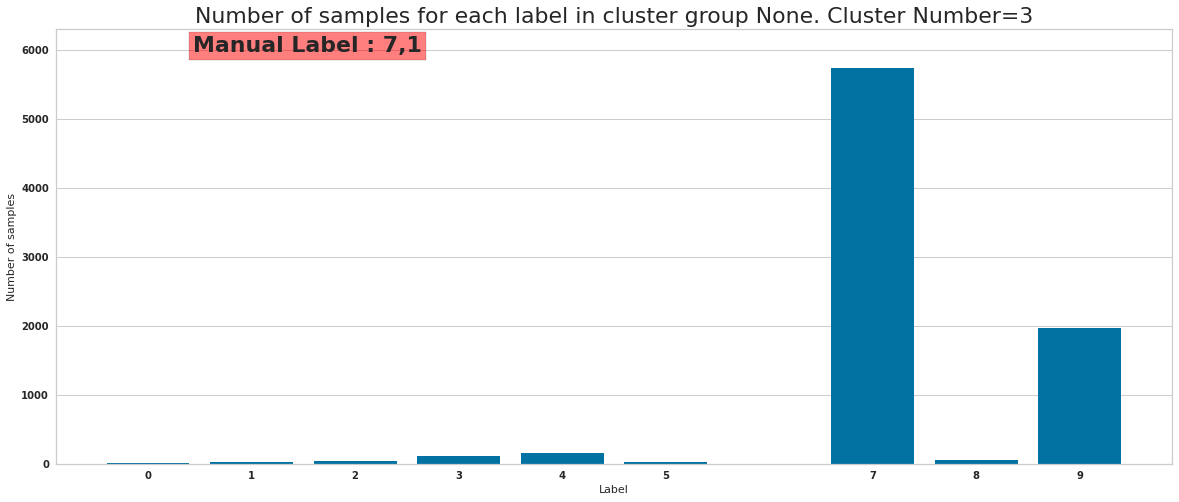

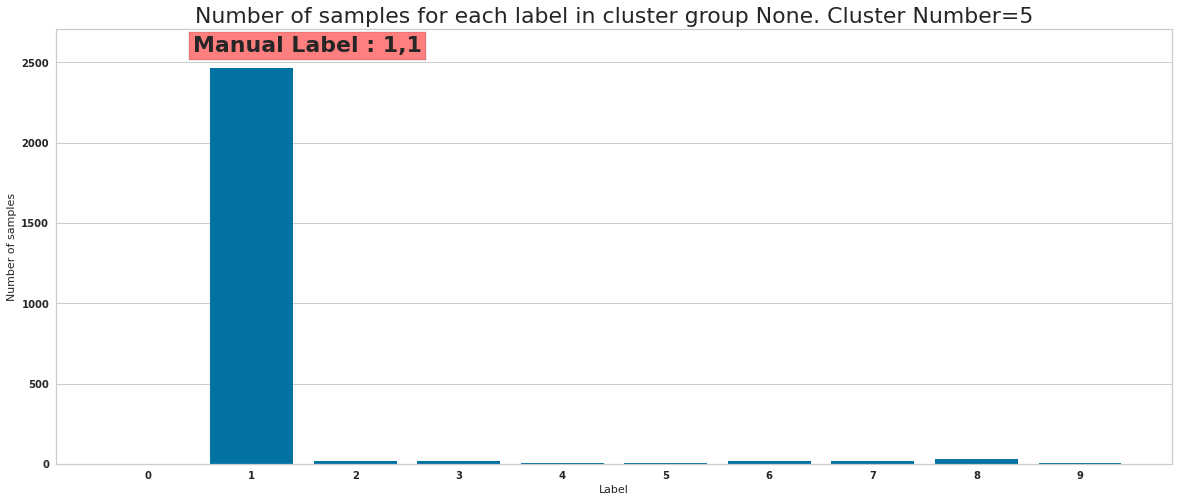

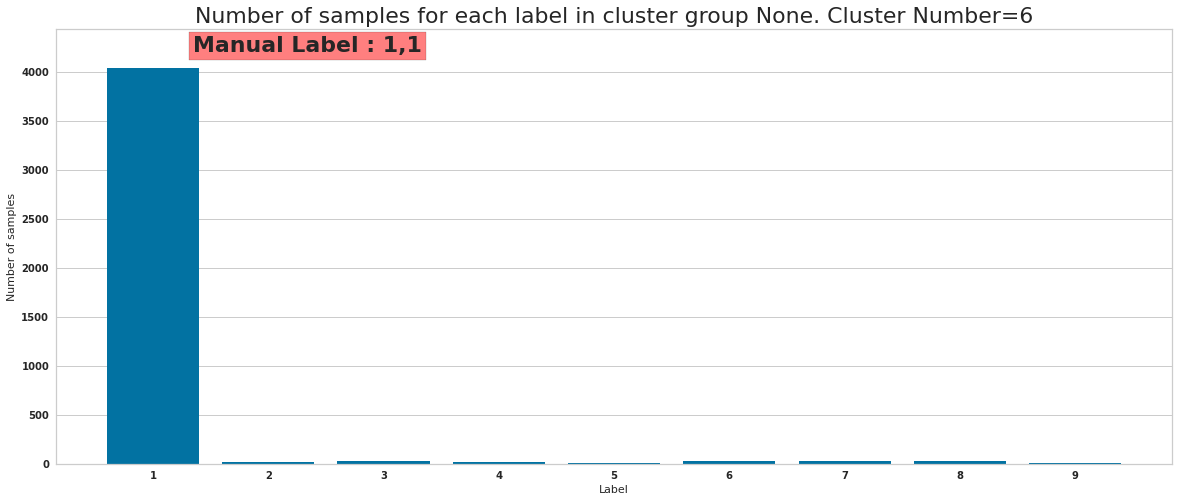

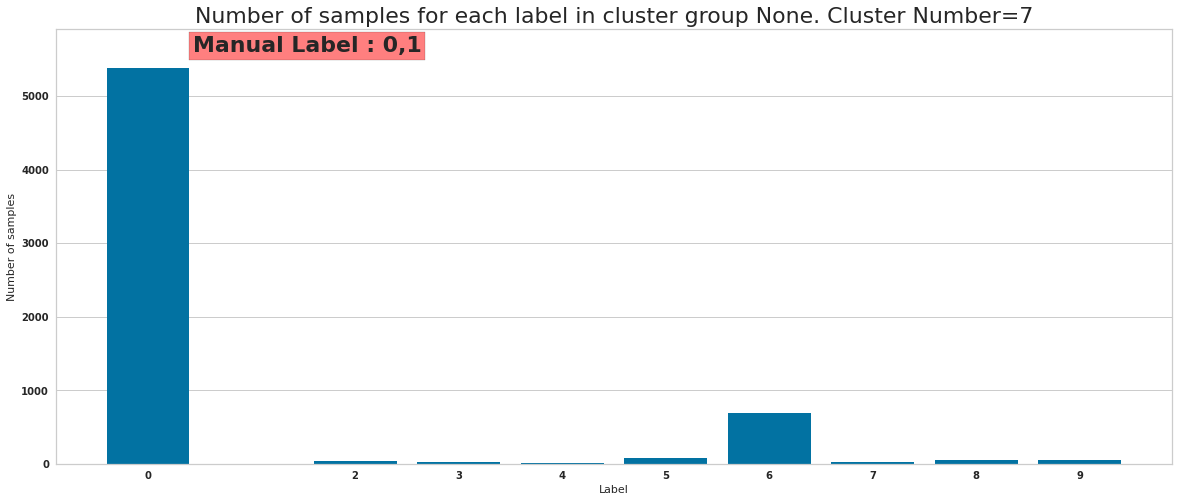

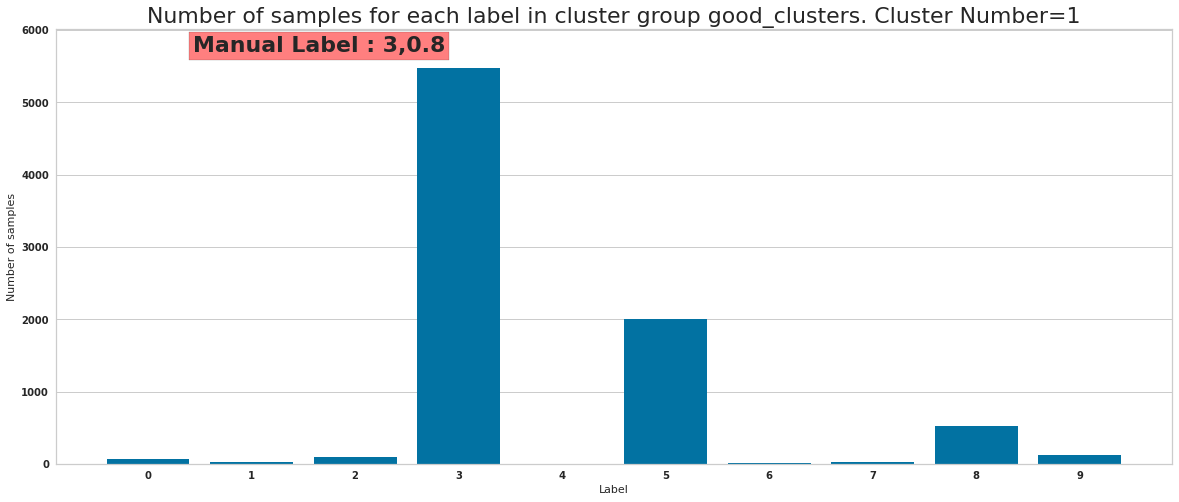

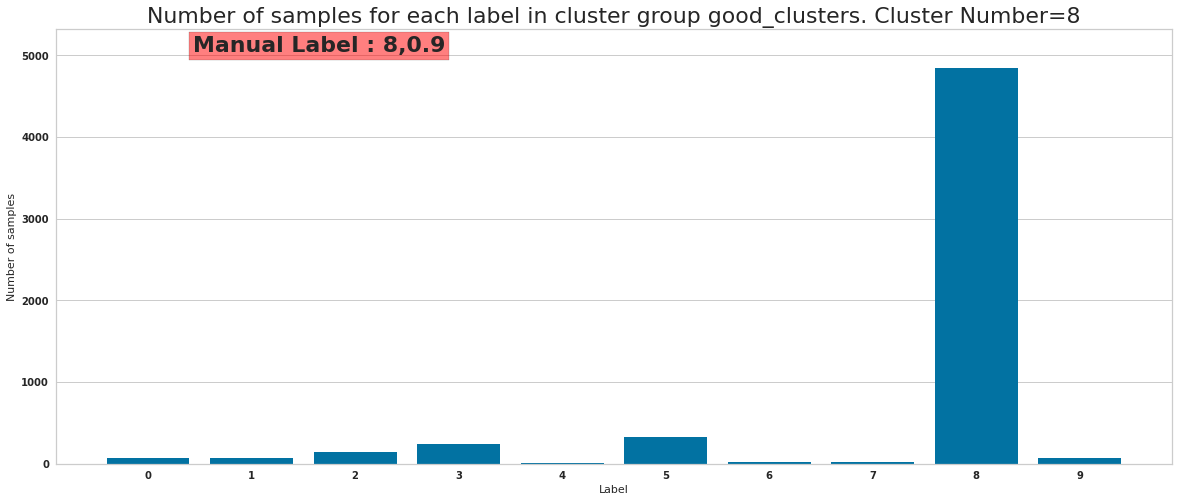

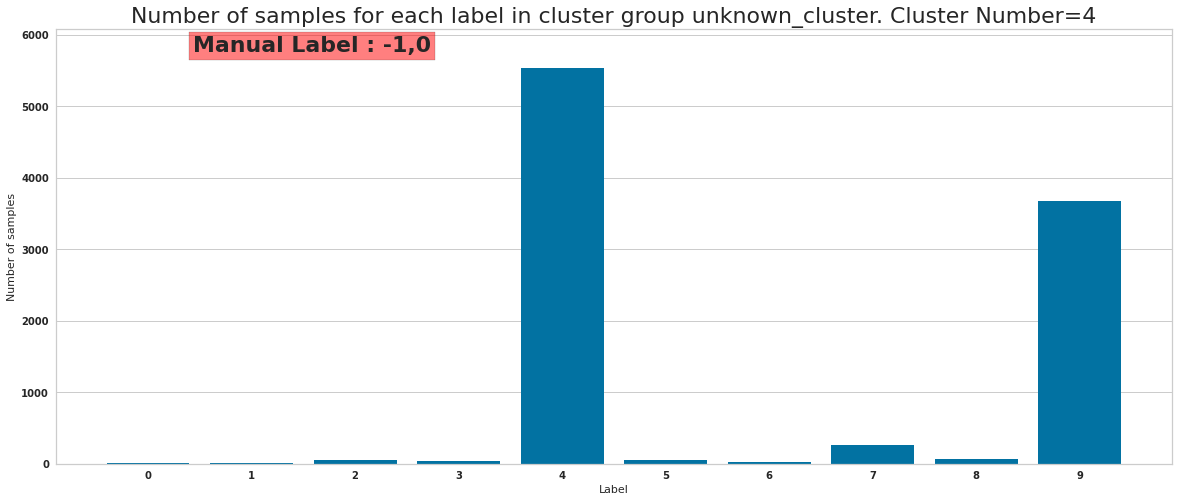

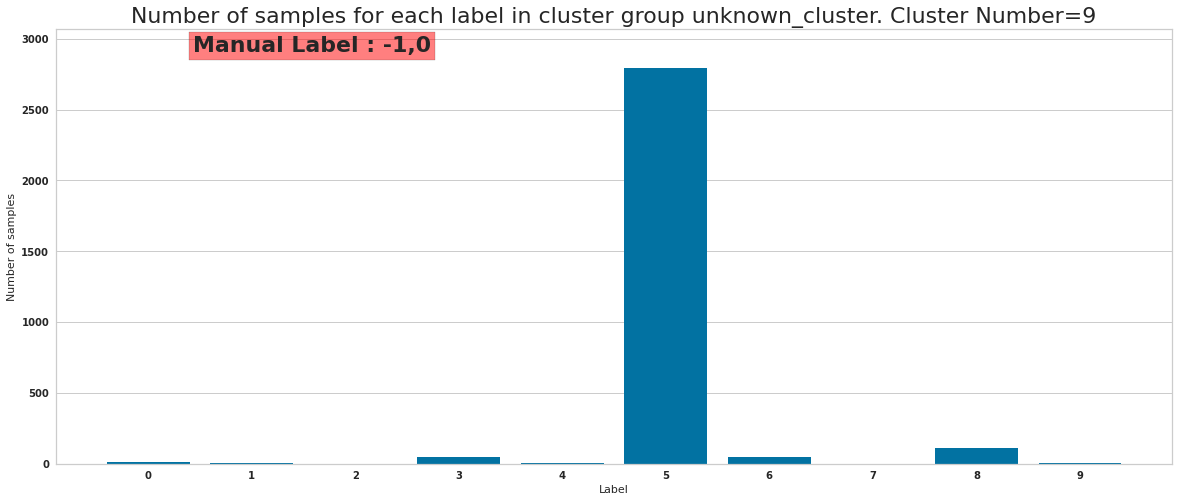

In [106]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [115]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

Posterior probability shape (59840, 10)


4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.mo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

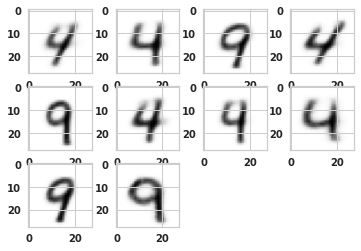

9
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.mo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

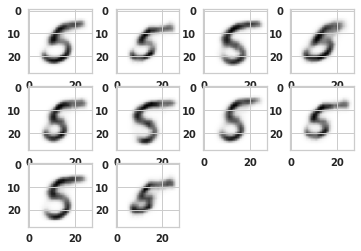

In [109]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [110]:

#TODO do this for all unknown clusters

level_2_cluster_dict = level2_manual_annotations[4]
level_2_cluster_dict["manual_labels"] = [-1, 4, 9, 4,
                                        9, 4, -1, -1,
                                        9, 9]
level_2_cluster_dict["manual_confidences"] = [0, 0.7, 0.8, 0.7,
                                             0.8, 0.6,  0, 0,
                                             0.8, 0.7]




level_2_cluster_dict = level2_manual_annotations[9]
level_2_cluster_dict["manual_labels"] = [5, 5, -1, -1,
                                        -1,-1,-1,-1,
                                        5, -1]
level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0,
                                             0,0,0,0,
                                             0.7, 0]



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [113]:
def process_second_level_clusters(df, cluster_group_dict, num_level_2_clusters, level2_manual_annotations,z_col_names, cluster_column_name_2,):
  print("Setting  next_level_clusters attribute to each primary cluster")
  for cluster_id in level2_manual_annotations.keys():
      _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
      _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

      print(cluster_id)
      level_2_cluster_dict = level2_manual_annotations[cluster_id]
      _indices =np.where( df[cluster_column_name].values == cluster_id)
      cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                      level_2_cluster_dict["manual_confidences"],
                                                      "cluster_level_2",
                                                      _cluster_centers,
                                                      _cluster_labels,
                                                      df,
                                                      _indices
                                                    )
      _, cluster = get_cluster(cluster_id, cluster_group_dict)
      cluster.set_next_level_clusters(cluster_level_2_group_dict)

  print("Computing distances from second level cluster centers")
  for cluster_id in level2_manual_annotations.keys():
      _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
      _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

      print(cluster_id)

      _, cluster = get_cluster(cluster_id, cluster_group_dict)
      num_level_2_clusters = cluster.next_lever_cluster_count()
      print(num_level_2_clusters)
      compute_distance_level_2(df, num_level_2_clusters, df[cluster_column_name].values, z_col_names, cluster, cluster_column_name_2)

  # impure_cluster = None
  # if "impure_cluster" in cluster_group_dict.keys():
  #     for cluster in cluster_group_dict["impure_cluster"]:
  #         print(cluster.id)
  #         _indices =np.where( cluster_labels == cluster.id)
  #         _df = df.iloc[_indices]
  #         _latent_vectors = _df[z_col_names].values
  #         _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
  #                                                                                             _latent_vectors,
  #                                                                                             exp_config)
  #         df[cluster_column_name_2].iloc[_indices] = _cluster_labels
  #         image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

  #         display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

  #         print(_df.iloc[_cluster_labels == 1].shape)
  #         print(_df.iloc[_cluster_labels == 0].shape)
  #         impure_cluster = cluster
          
  # level_2_cluster_dict = dict()
  # if "impure_cluster" in cluster_group_dict.keys():
  #     cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
  #                                                     level_2_cluster_dict["manual_confidences"],
  #                                                     "cluster_level_2",
  #                                                     _cluster_centers,
  #                                                     _cluster_labels,
  #                                                     df,
  #                                                     _indices
  #                                                   )
  #     impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
      
  # if "impure_cluster" in cluster_group_dict.keys():

  #     for cluster in cluster_group_dict["impure_cluster"]:
  #         num_level_2_clusters = cluster.next_lever_cluster_count()
  #         print(num_level_2_clusters)
  #         for i in range(num_level_2_clusters):
  #             df[f"distance_level_2_{cluster.id}_{i}"] = 100000
  #         for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
  #             #print(level_2_cluster.id)
  #             indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
  #             #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
  #             cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
  #             print(level_2_cluster.id, indices.shape)
  #             df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
  #                                                                                                                               cluster_centers_level_2,
  #                                                                                                                               z_col_names), axis=1)



In [116]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  num_level_2_clusters,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
4
9
Computing distances from second level cluster centers
4
10
Skipping distance computation for unknown cluster
1 (1187,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


2 (704,)
3 (1026,)
4 (1430,)
8 (1020,)
9 (694,)
5 (941,)
9
10
0 (308,)
1 (613,)
8 (271,)
Skipping distance computation for unknown cluster
Manual Label 6
(5581, 97) (5581, 43)
Num correct=5025
Cluster 0 Manual Label 6 Percentage correct 90.03762766529296
********************************
Manual Label 3
(8341, 97) (8341, 43)
Num correct=5469
Cluster 1 Manual Label 3 Percentage correct 65.56767773648244
********************************
Manual Label 2
(6036, 97) (6036, 43)
Num correct=5492
Cluster 2 Manual Label 2 Percentage correct 90.98740888005301
********************************
Manual Label 7
(8132, 97) (8132, 43)
Num correct=5726
Cluster 3 Manual Label 7 Percentage correct 70.4131824889326
********************************
unknown
<class 'dict'>
['unknown_cluster', 'good_clusters', 'average_clusters']
4
Second level cluster id 0
********-1*******
Annotating individual samples (883,)
Second level cluster id 6
********-1*******
Annotating individual samples (1193,)
Second level cluster 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [117]:
num_individual_samples_annotated

4583

In [118]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5581., 8341., 6036., 8132., 9750., 2582., 4199., 6362., 5830.,
        3027.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

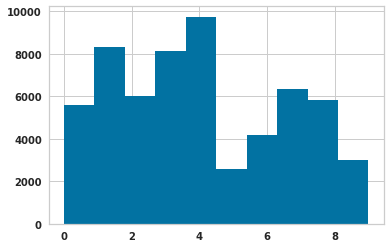

In [119]:
plt.hist(cluster_labels)

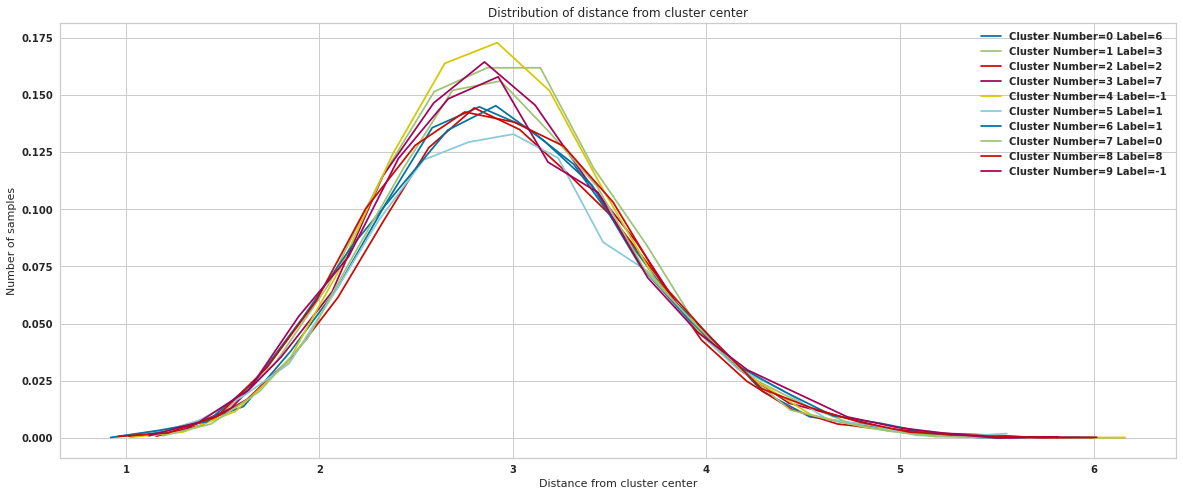

In [120]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

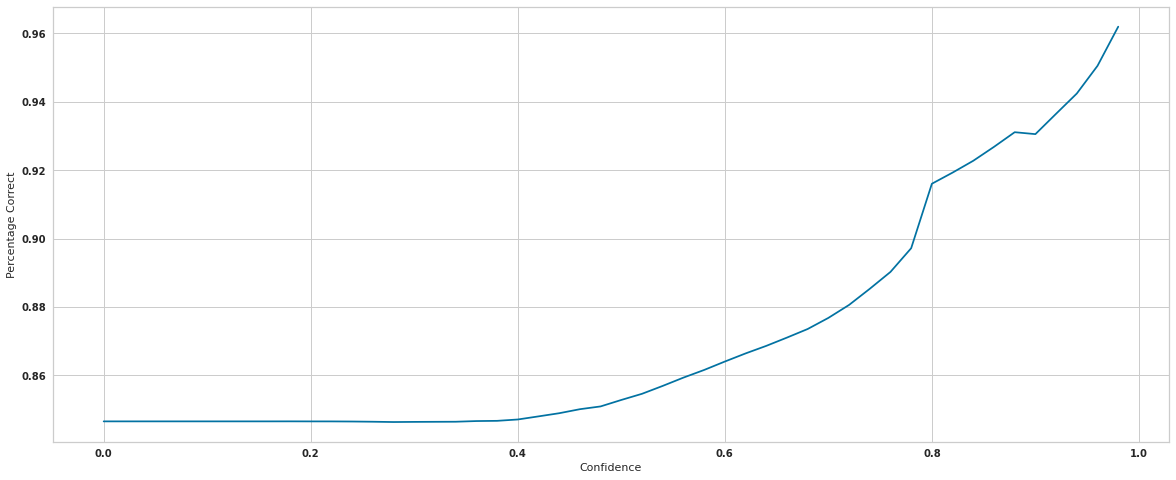

In [121]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

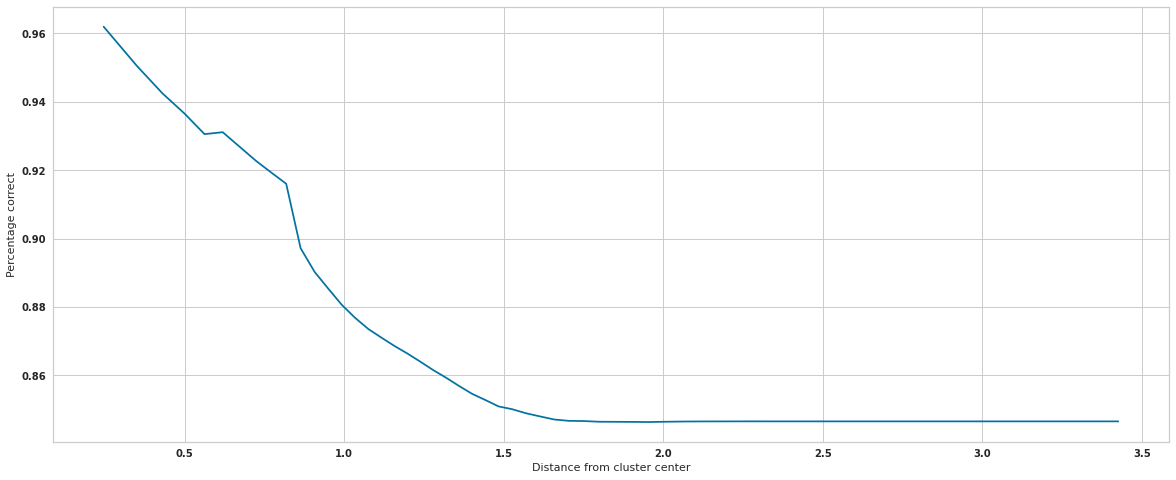

In [122]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [123]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3


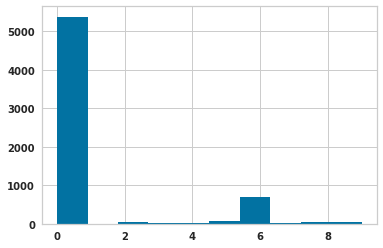

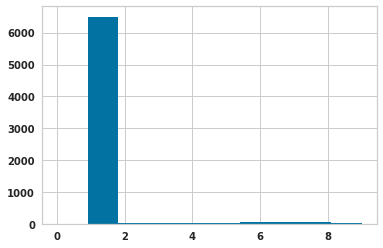

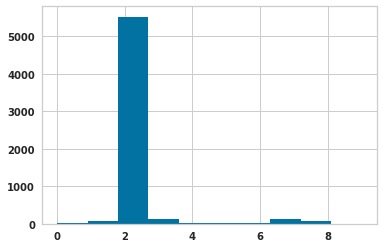

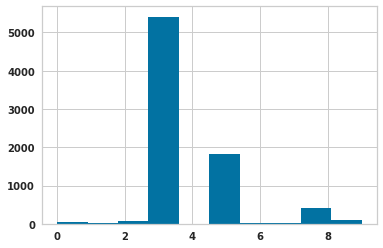

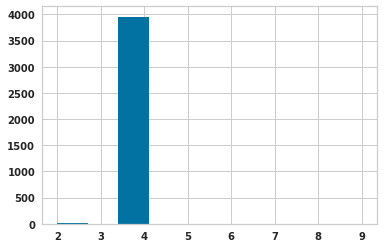

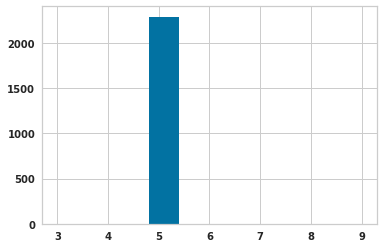

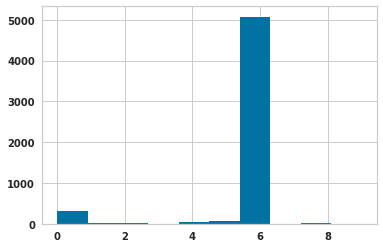

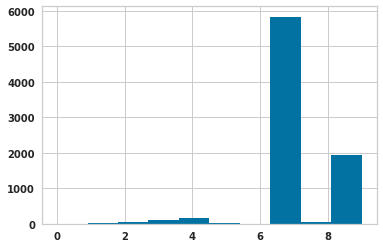

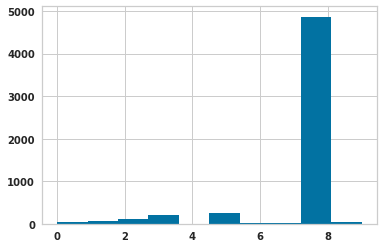

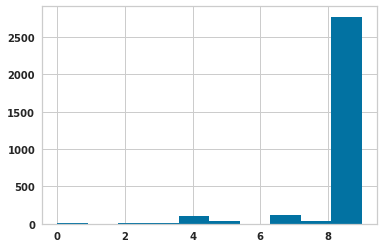

In [124]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [125]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)

In [126]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [127]:
num_epochs
num_epochs += 1
print(num_epochs)

4


In [128]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_3.0.csv


In [129]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        learning_rate=1e-4,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100_gmm_prob'}
Loaded manual annotation
Number

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.mode

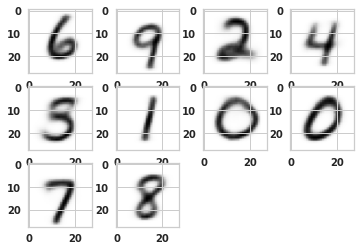

In [131]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

# if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
#     num_clusters = visualizer.elbow_value_
# else:
#     num_clusters = 2 * visualizer.elbow_value_
# if num_clusters < 10:
#     num_clusters = 10
num_clusters = 10
print(f"Number of clusters {num_clusters}")

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [132]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 9, 2, 4,
                                           -1, 1, 0, 0,
                                           7, 8
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               0, 1, 0.8, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


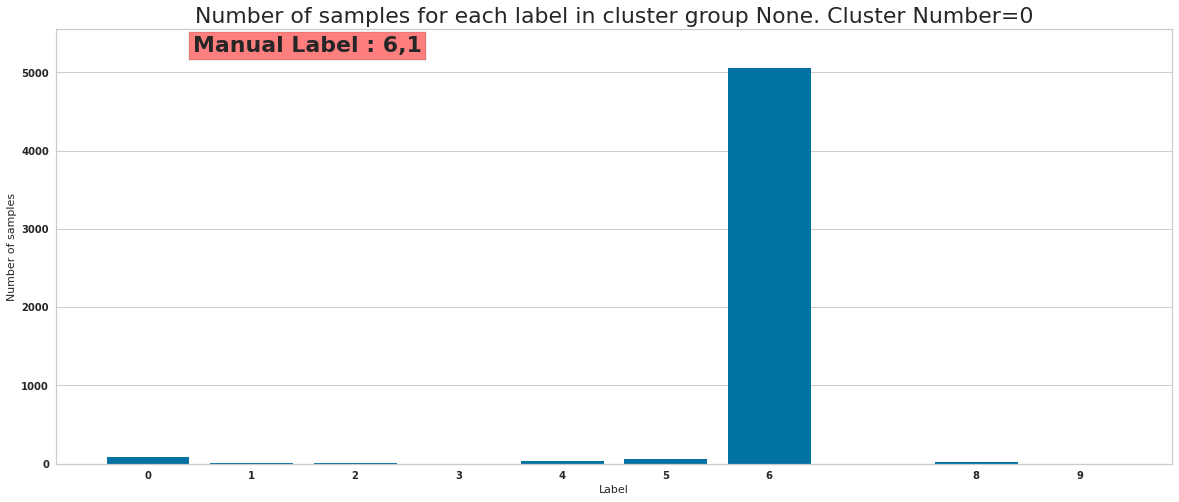

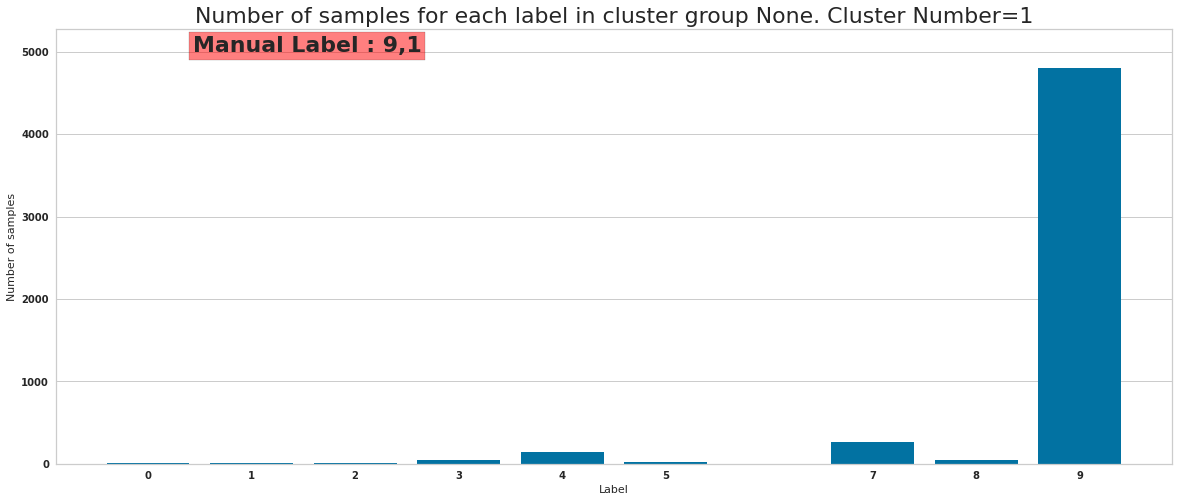

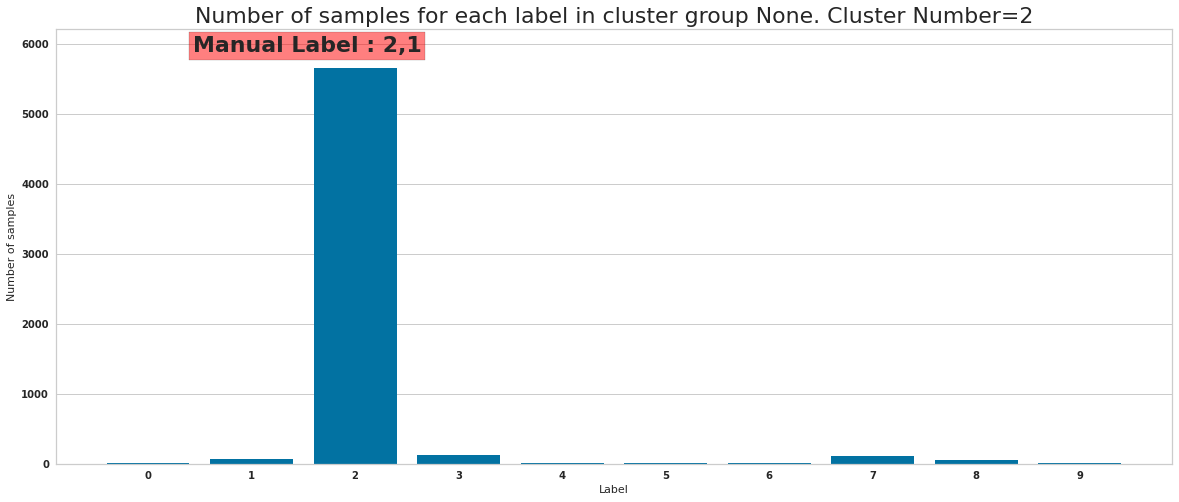

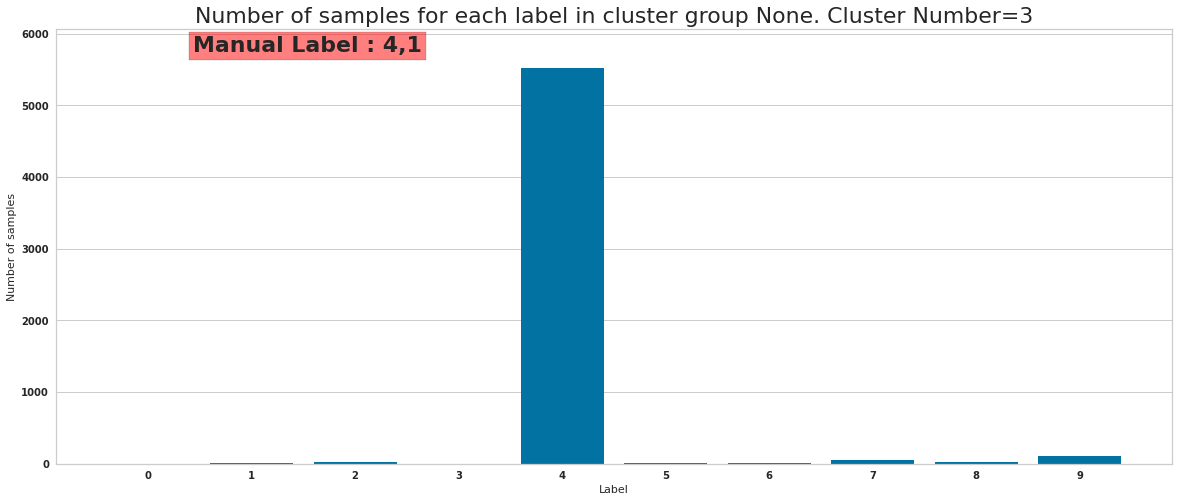

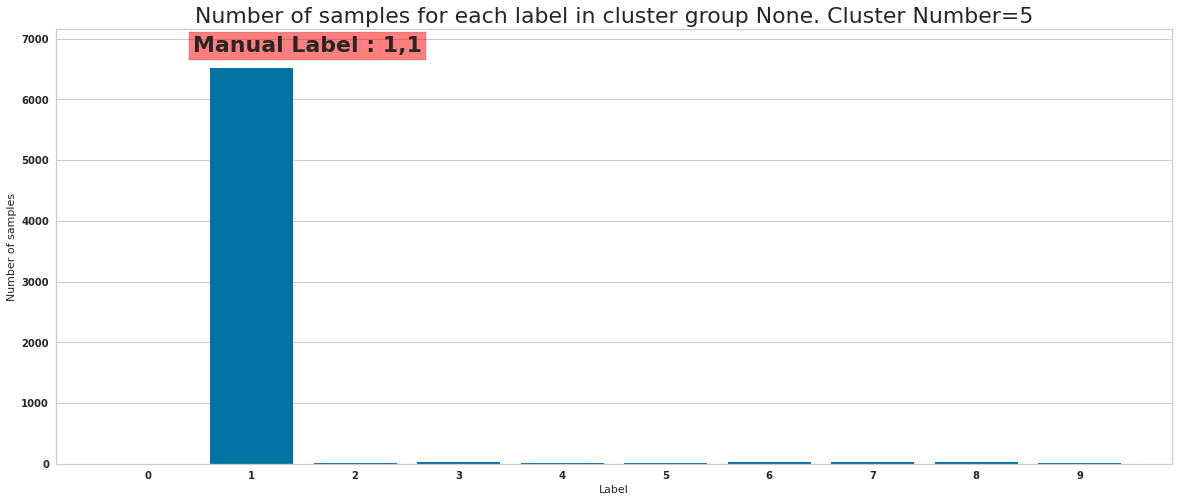

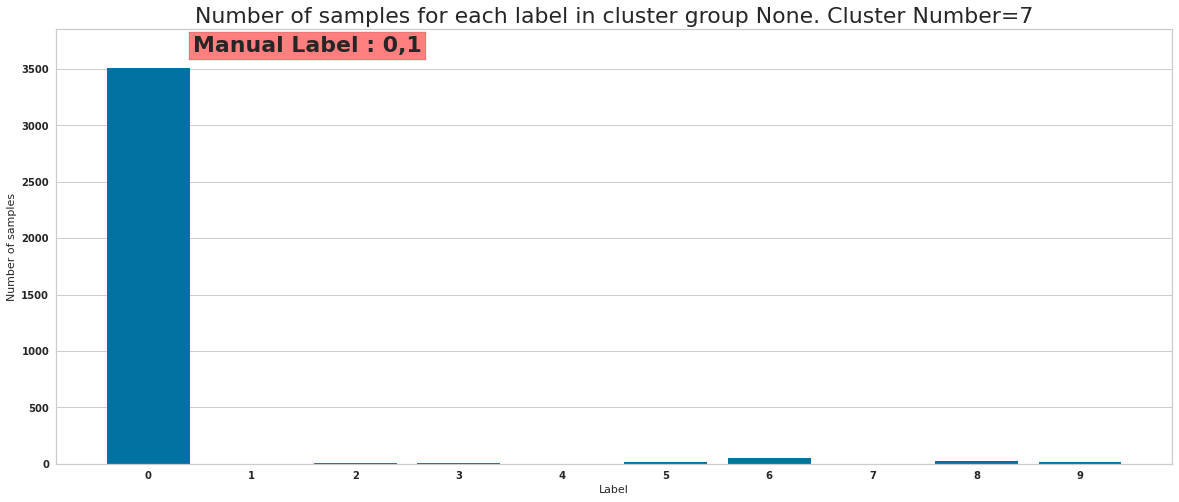

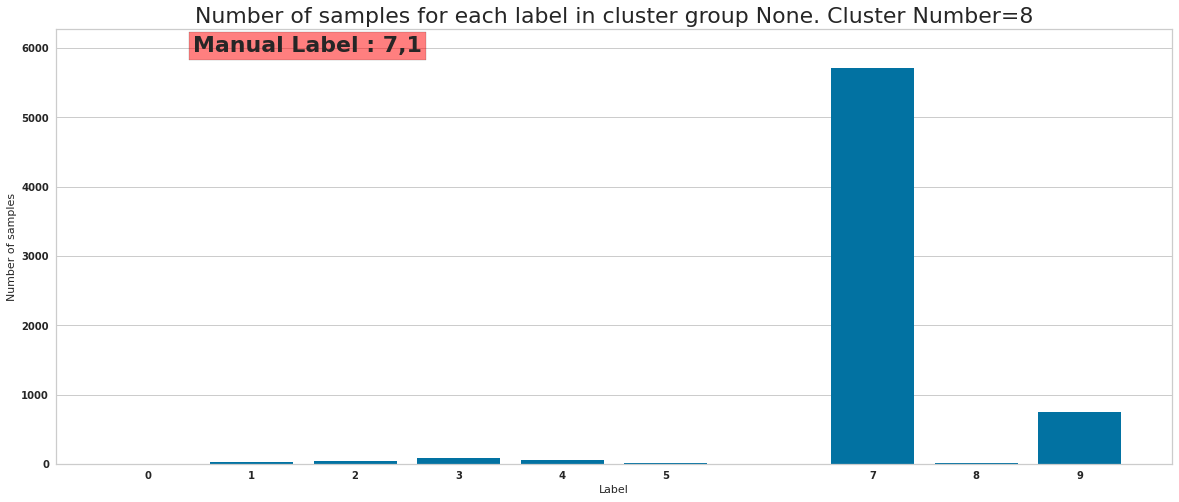

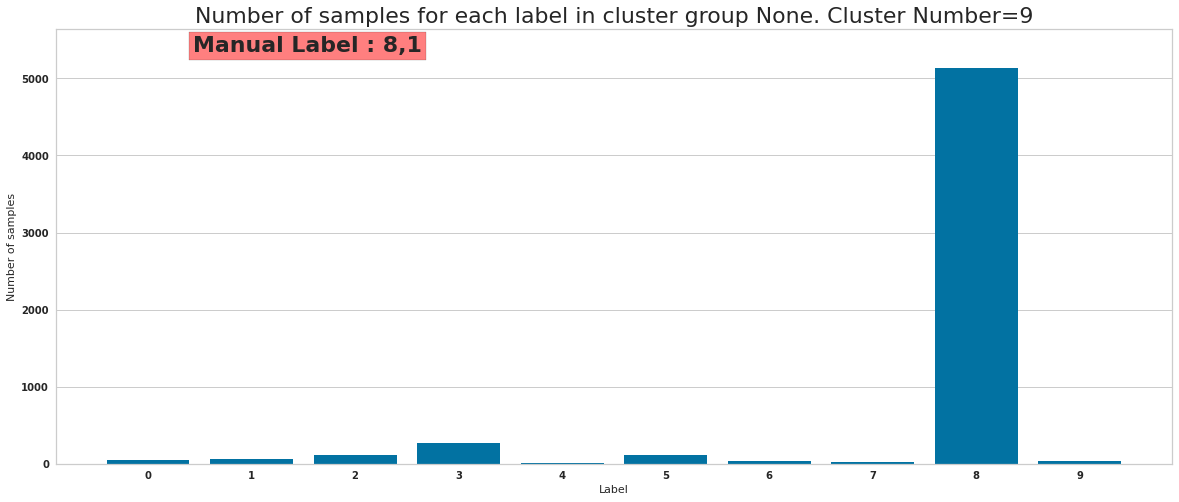

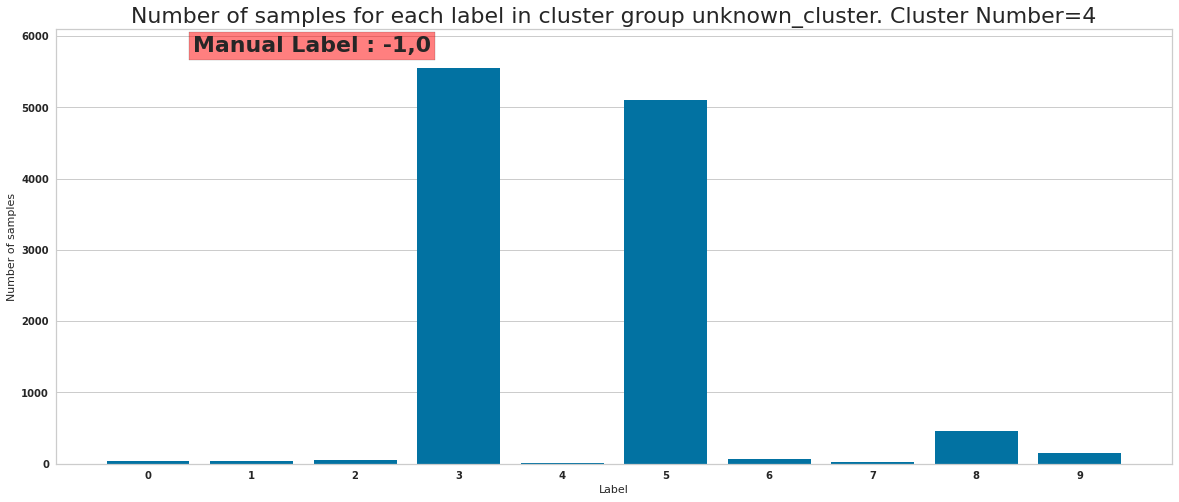

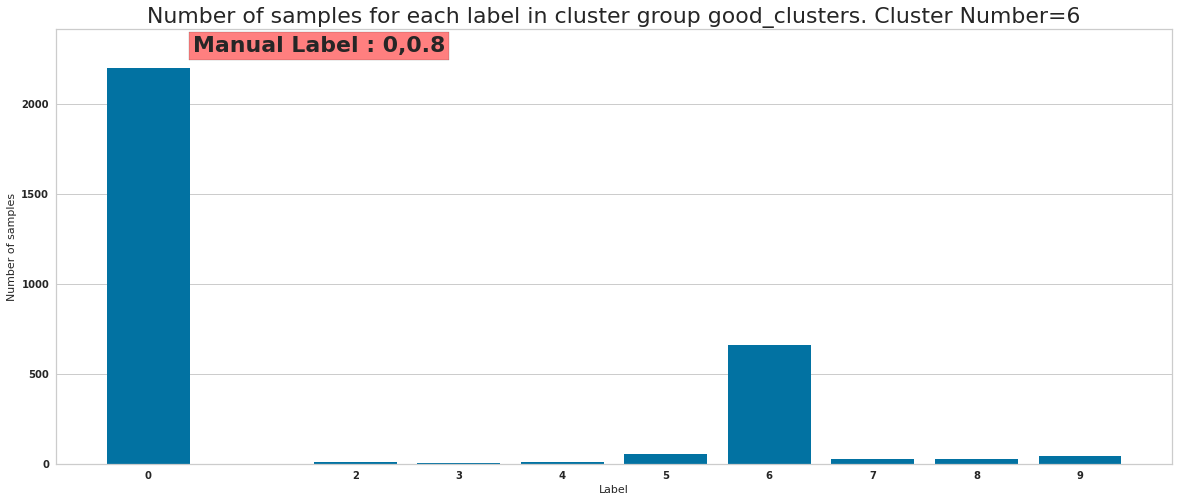

In [134]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

(5272, 10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(5342, 10)
(6078, 10)
(5757, 10)
(11487, 10)
(6690, 10)
(3040, 10)
(3632, 10)
(6686, 10)
(5856, 10)
Posterior probability shape (59840, 10)
4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

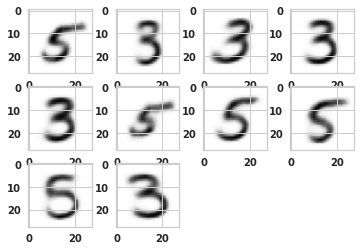

In [135]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [136]:
level_2_cluster_dict = level2_manual_annotations[4]

level_2_cluster_dict["manual_labels"] = [5, 3, 3, 3,
                                         3, -1, 5, 5,
                                         -1, 3
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.8,0.6,0.6,0.8,
                                             0.8,0,0.9,0.75,
                                             0.7,0.8]

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [137]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  num_level_2_clusters,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
4
Computing distances from second level cluster centers
4
10
0 (1241,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


3 (1923,)
4 (1114,)
6 (852,)
7 (1006,)
9 (1218,)
1 (1176,)
2 (1110,)
Skipping distance computation for unknown cluster
Manual Label 6
(5272, 77) (5272, 33)
Num correct=5049
Cluster 0 Manual Label 6 Percentage correct 95.7701062215478
********************************
Manual Label 9
(5342, 77) (5342, 33)
Num correct=4797
Cluster 1 Manual Label 9 Percentage correct 89.79782852864096
********************************
Manual Label 2
(6078, 77) (6078, 33)
Num correct=5644
Cluster 2 Manual Label 2 Percentage correct 92.85949325435999
********************************
Manual Label 4
(5757, 77) (5757, 33)
Num correct=5513
Cluster 3 Manual Label 4 Percentage correct 95.76168143130103
********************************
unknown
<class 'dict'>
['good_clusters', 'average_clusters', 'unknown_cluster']
4
Second level cluster id 0
********5*******
Manual_label 5
Second level cluster id 3
********3*******
Manual_label 3
Second level cluster id 4
********3*******
Manual_label 3
Second level cluster id 6
****

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [138]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [139]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4


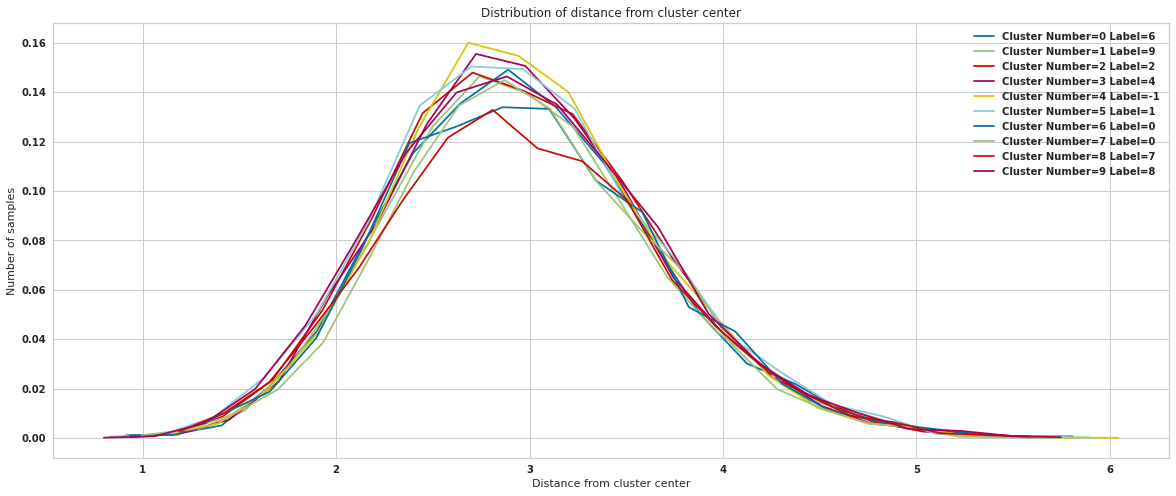

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

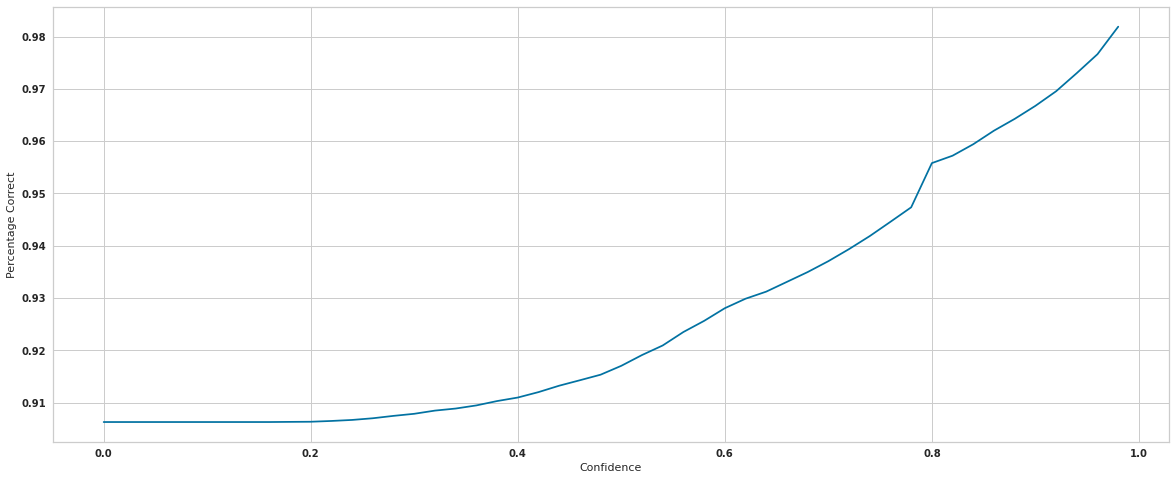

In [141]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

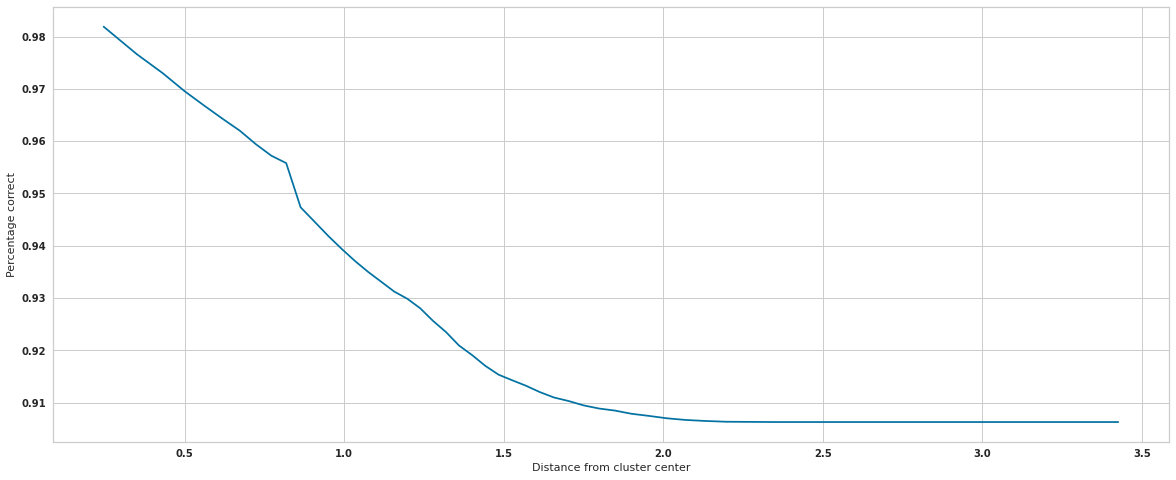

In [142]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

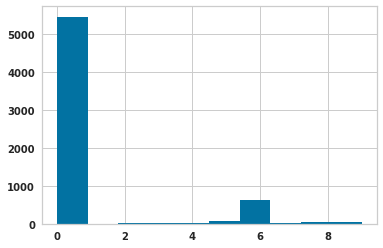

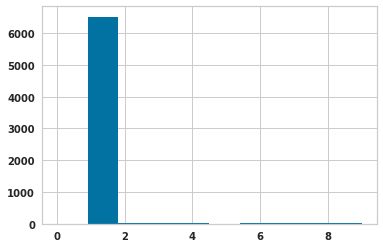

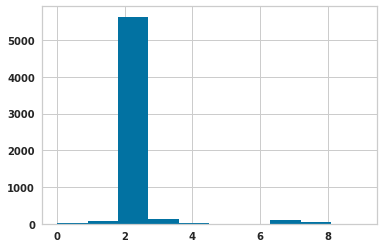

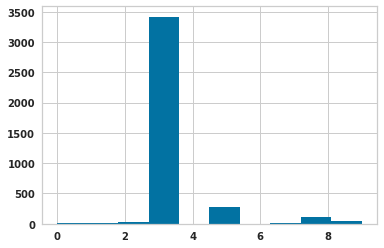

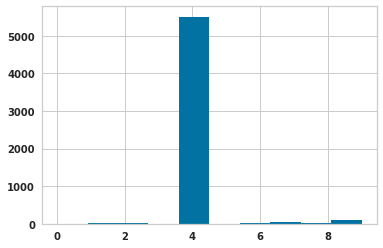

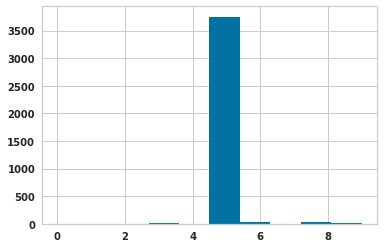

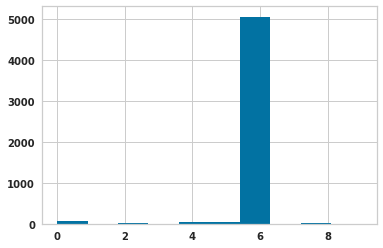

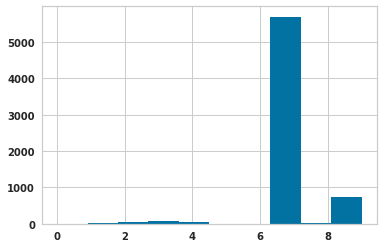

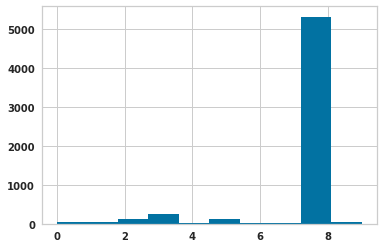

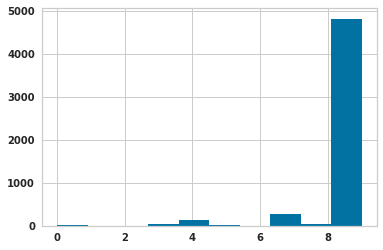

In [143]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [144]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

# manual_annotation_df = None
# if os.path.isfile(manual_annotation_file):
#     print("Reading existing manual annotation file")
#     manual_annotation_df = pd.read_csv(manual_annotation_file)

# epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

# if manual_annotation_df is not None:
#     manual_annotation_df[epoch_col_label] = df["manual_annotation"]
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
# else:
#     print("No existing manual annotation file. Creating new manual annotation dataframe")
#     manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

# all_columns = list(manual_annotation_df.columns)
# previous_epochs_completed = []
# for i in range(int(epochs_completed) + 1):
#     epoch_col_label = f"manual_label_{i}"
#     print(epoch_col_label)
#     if epoch_col_label in all_columns:
#         previous_epochs_completed.append(i)


# manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
#                                                                                        previous_epochs_completed),
#                                                      axis=1)
# manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
#                                                                                                   previous_epochs_completed),
#                                                                 axis=1)

        

# manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

# Iteration 4

In [145]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [146]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        root_path=root_path,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100_gmm_prob'}
Loaded manual annotation
Number 

In [147]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.mode

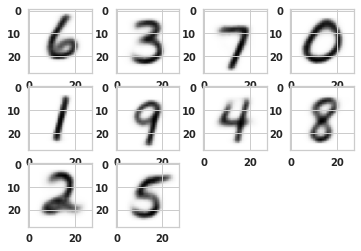

In [149]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                    )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [150]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 3, 7, 0,
                                           1, 9, 4, 8,
                                           2, 5
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


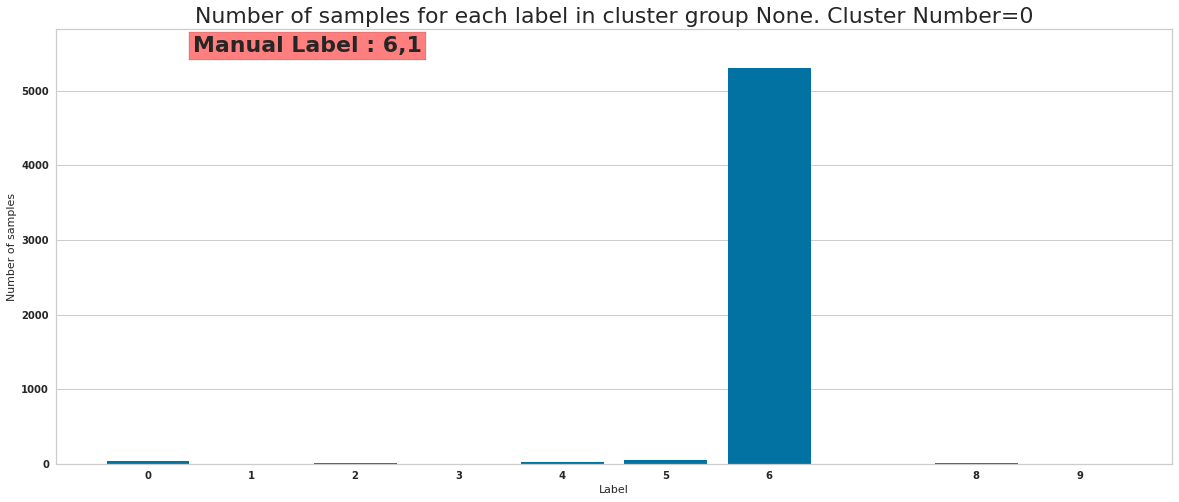

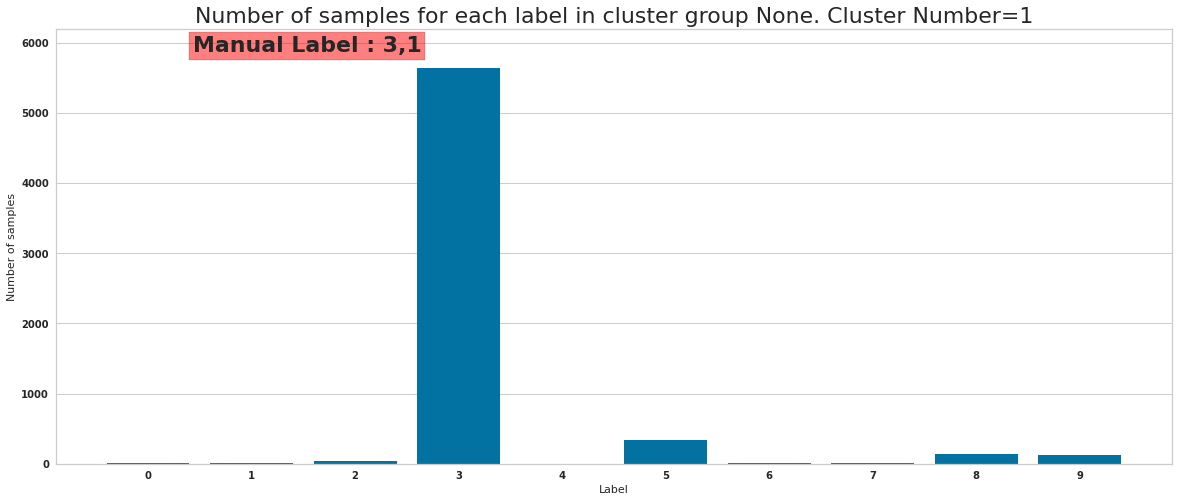

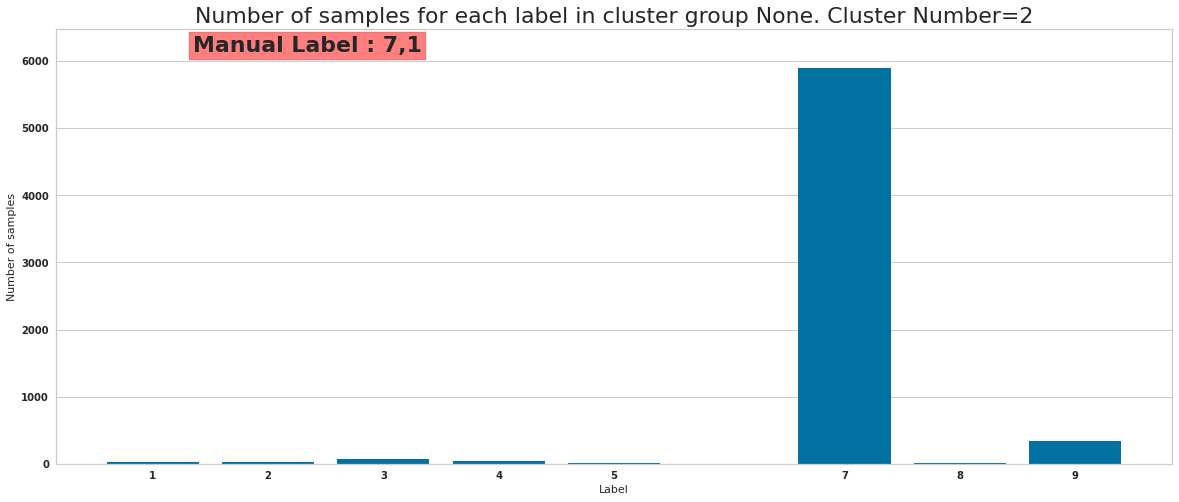

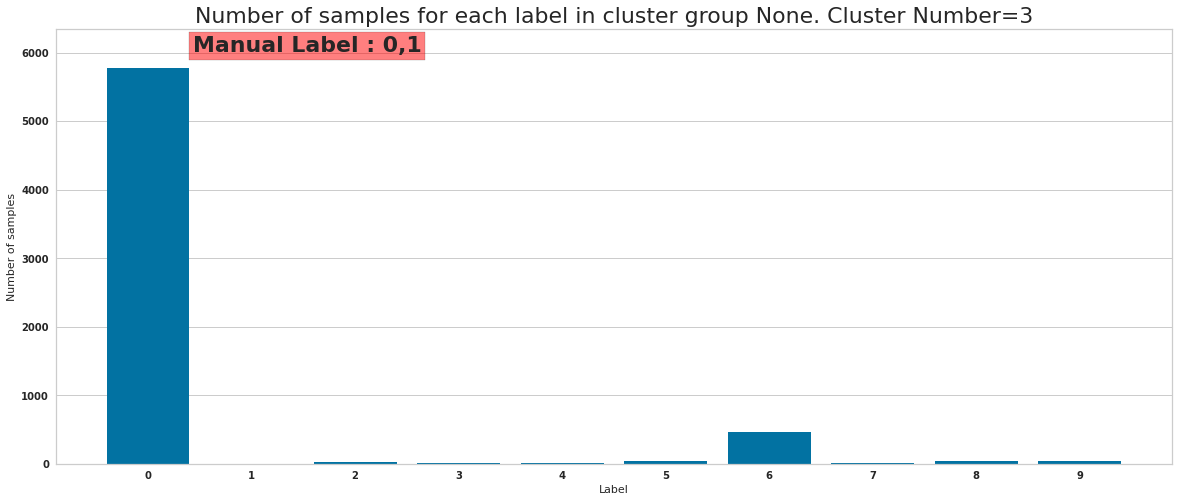

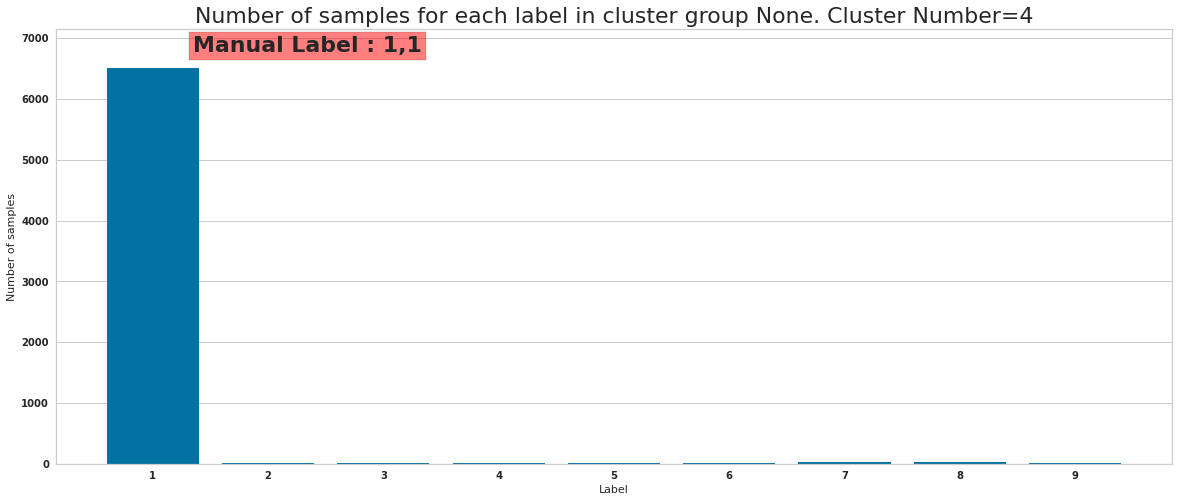

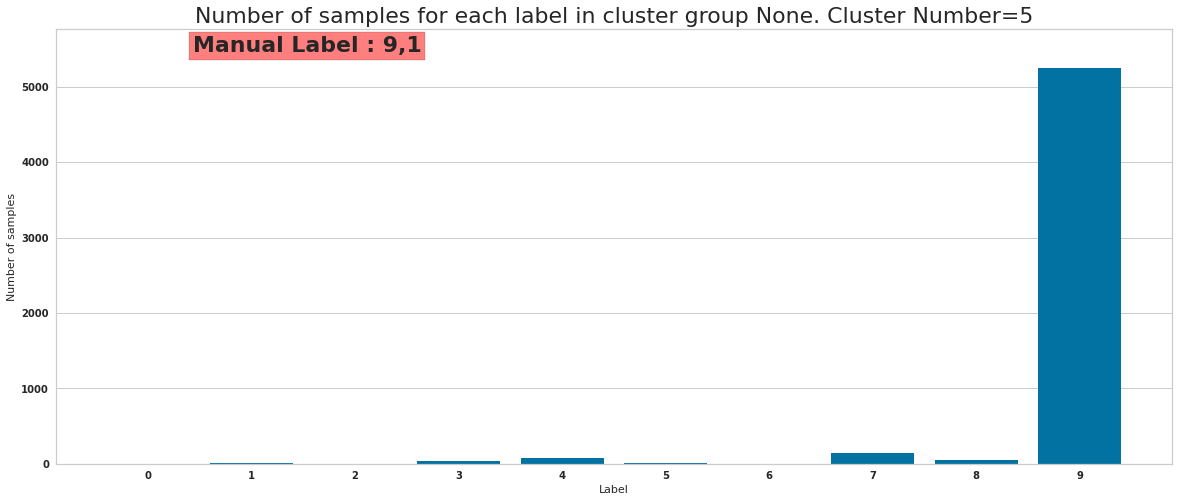

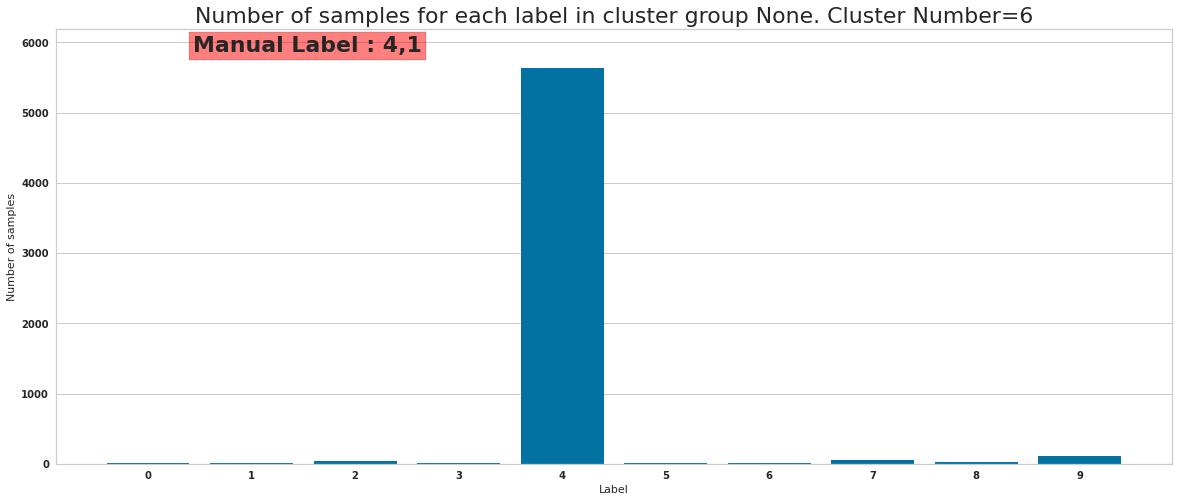

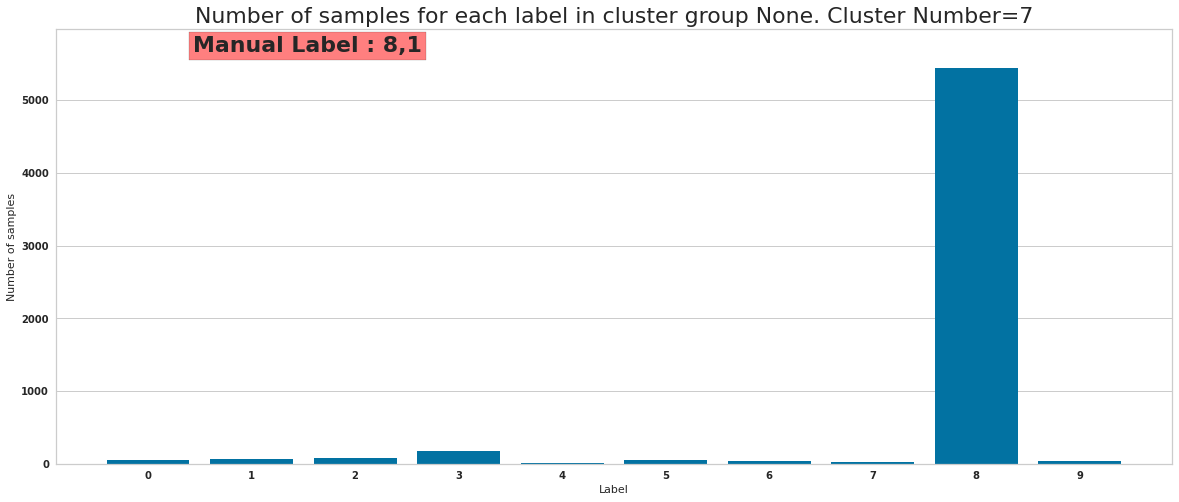

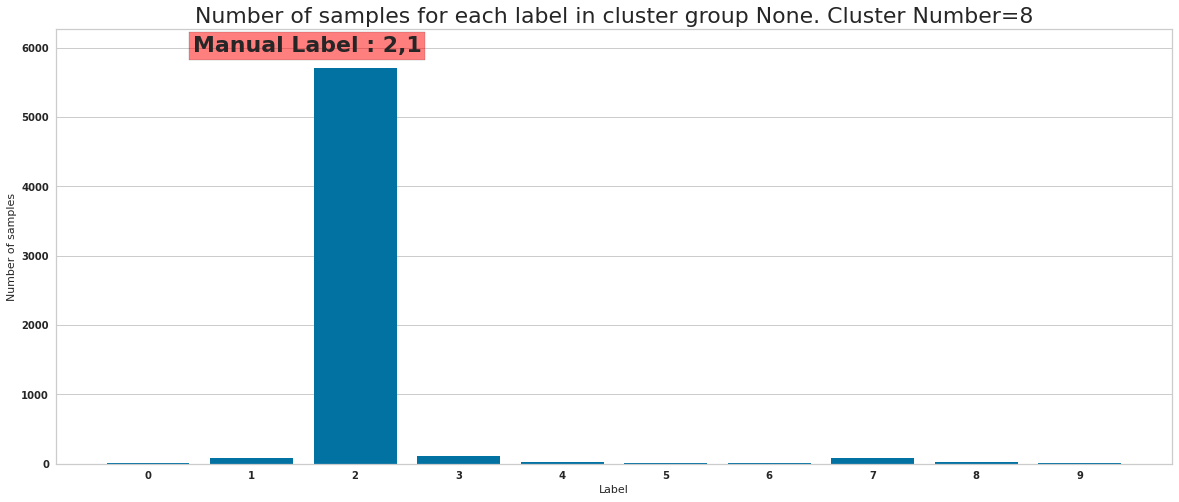

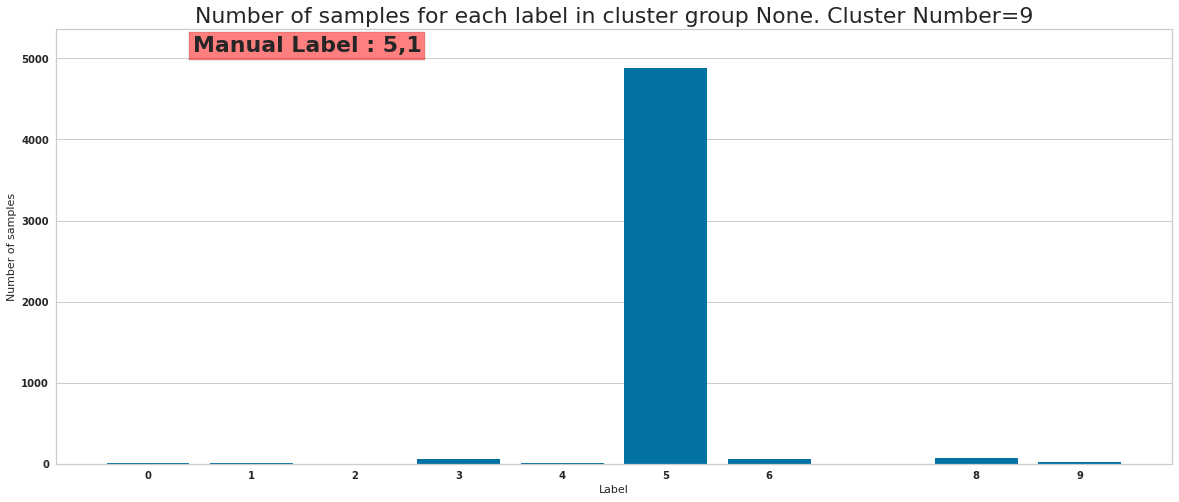

In [151]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [152]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(5433, 10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(6326, 10)
(6390, 10)
(6442, 10)
(6619, 10)
(5571, 10)
(5899, 10)
(5973, 10)
(6080, 10)
(5107, 10)
Posterior probability shape (59840, 10)


In [ ]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [153]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  num_level_2_clusters,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
Computing distances from second level cluster centers
Manual Label 6
(5433, 57) (5433, 33)
Num correct=5296
Cluster 0 Manual Label 6 Percentage correct 97.47837290631327
********************************
Manual Label 3
(6326, 57) (6326, 33)
Num correct=5633
Cluster 1 Manual Label 3 Percentage correct 89.04521024343977
********************************
Manual Label 7
(6390, 57) (6390, 33)
Num correct=5888
Cluster 2 Manual Label 7 Percentage correct 92.14397496087636
********************************
Manual Label 0
(6442, 57) (6442, 33)
Num correct=5770
Cluster 3 Manual Label 0 Percentage correct 89.56845700093139
********************************
Manual Label 1
(6619, 57) (6619, 33)
Num correct=6502
Cluster 4 Manual Label 1 Percentage correct 98.23236138389485
********************************
Manual Label 9
(5571, 57) (5571, 33)
Num correct=5242
Cluster 5 Manual Label 9 Percentage correct 94.09441751929636
**********************

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [154]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5


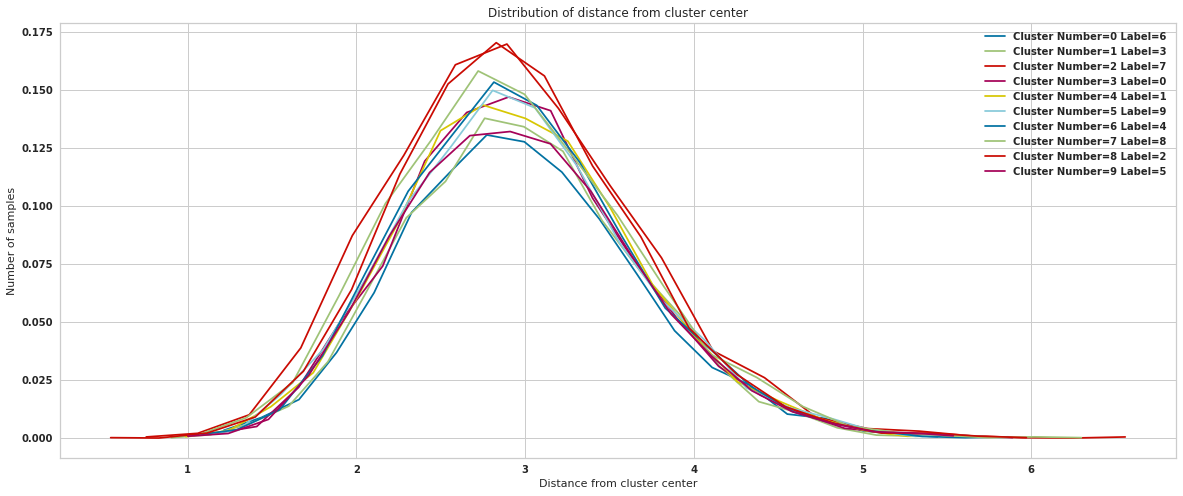

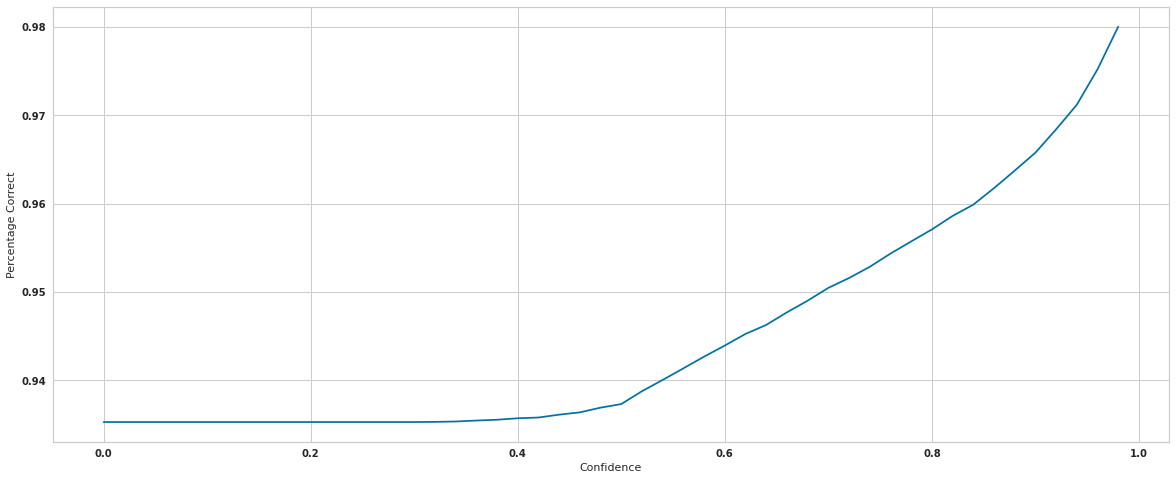

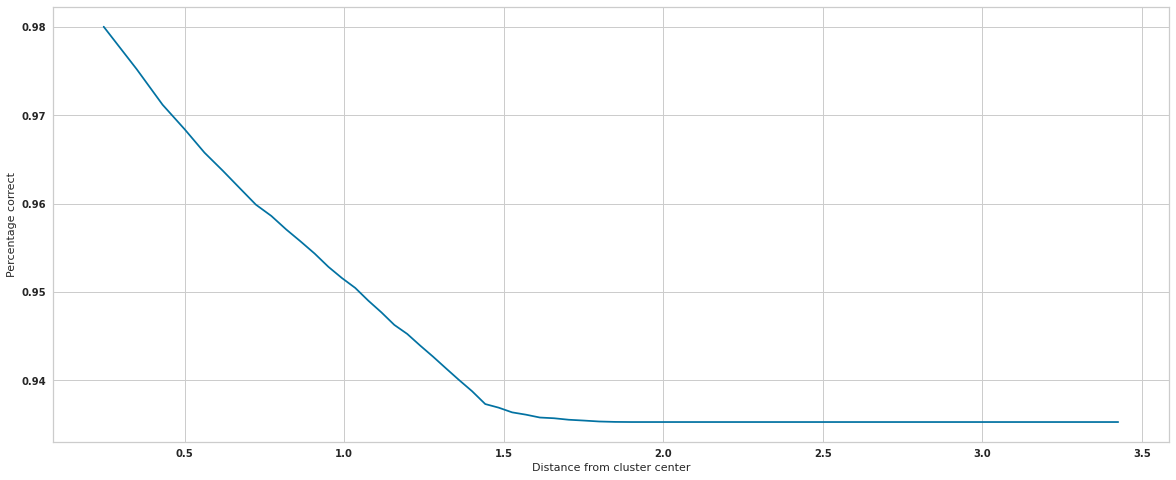

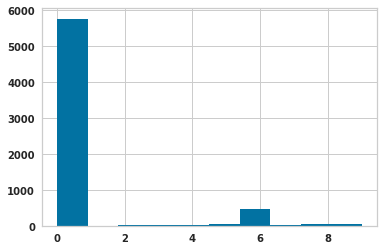

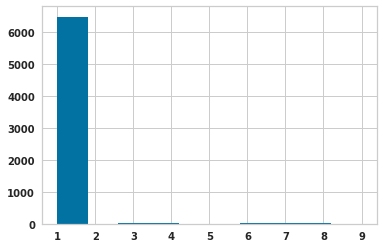

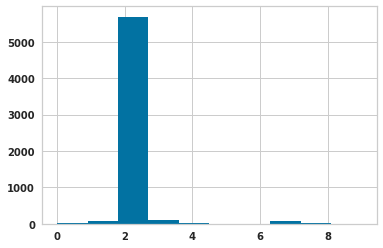

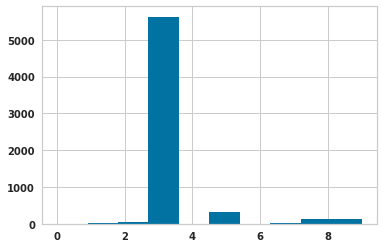

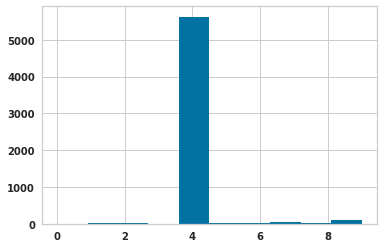

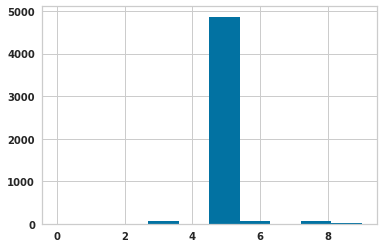

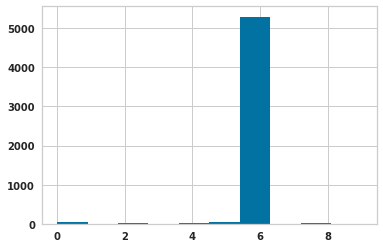

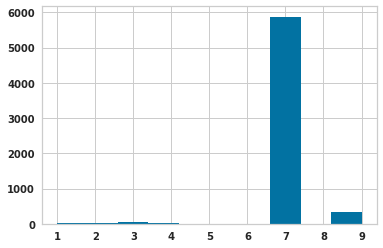

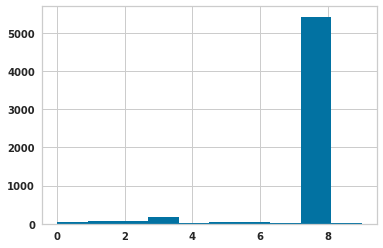

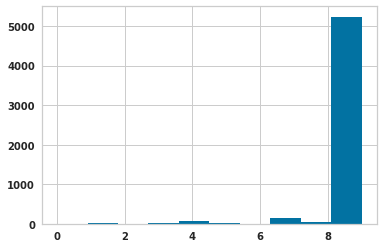

In [155]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [156]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100_gmm_prob'}


Exception: ignored

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

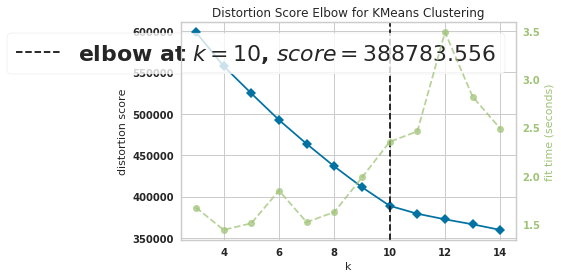

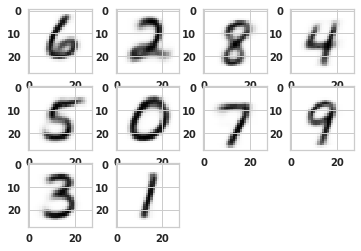

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


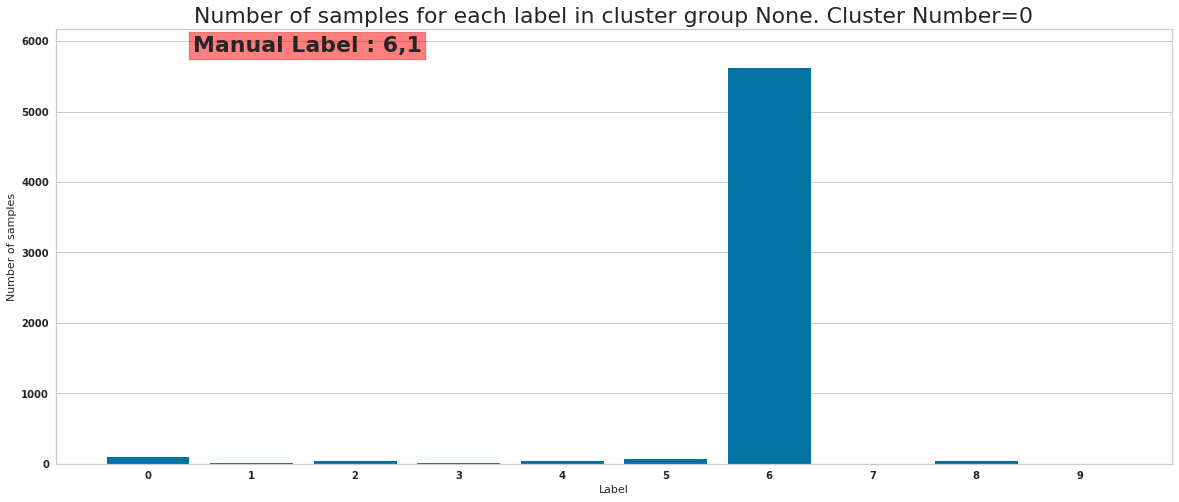

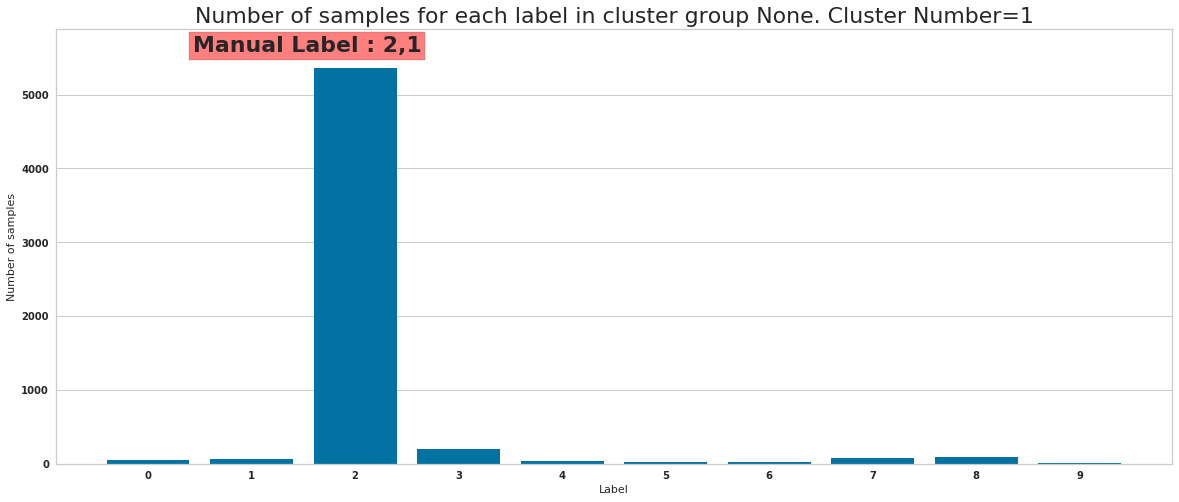

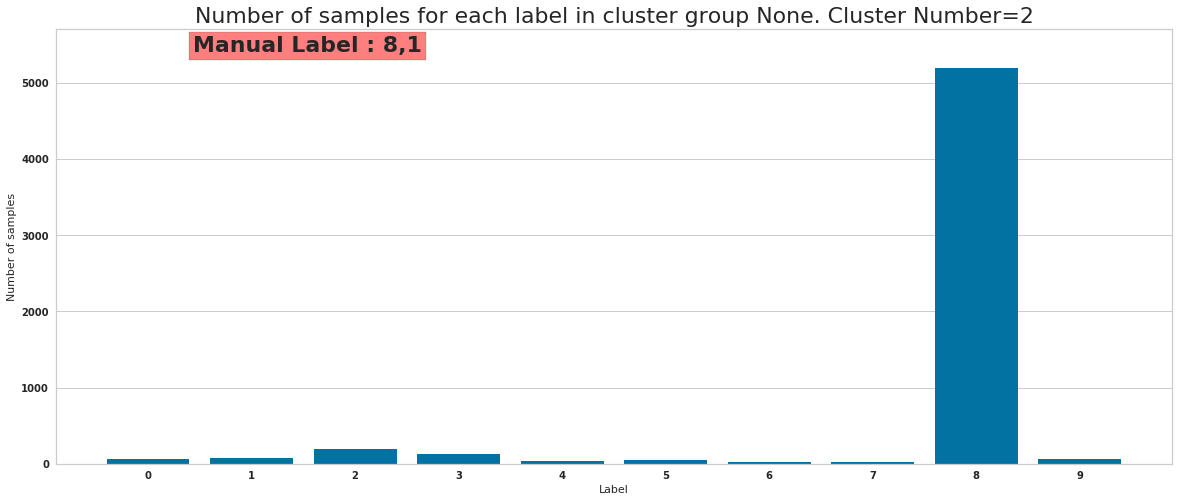

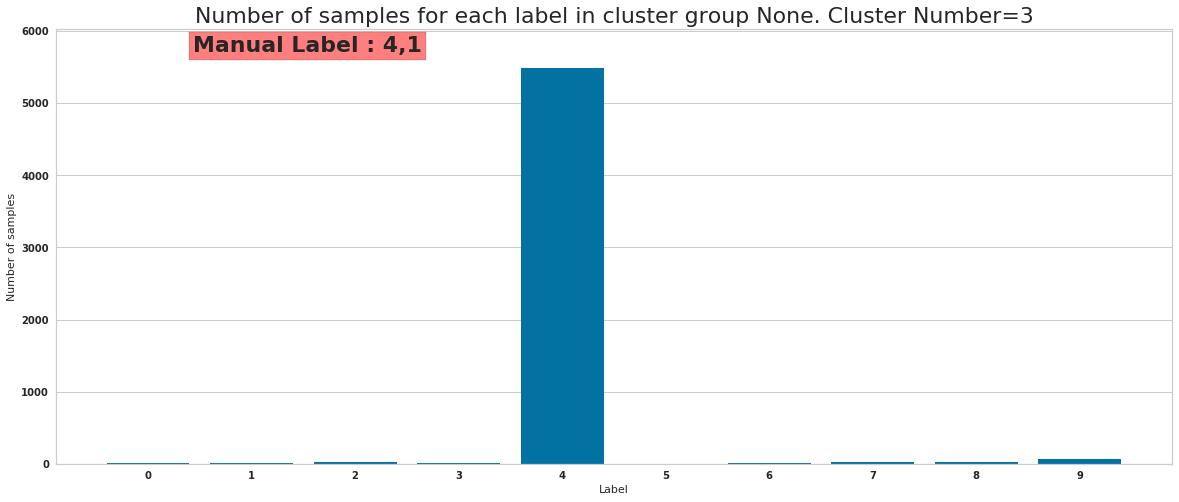

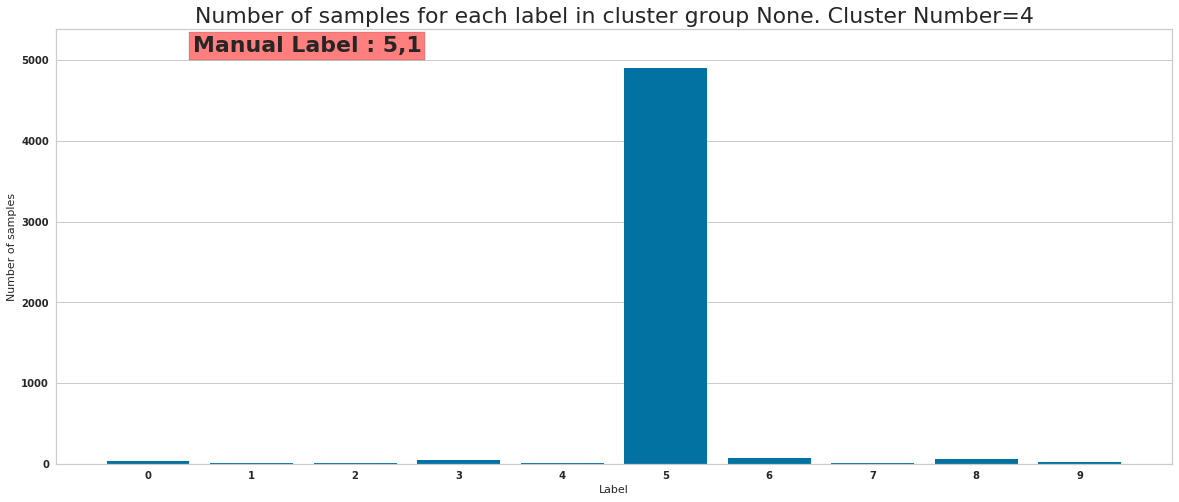

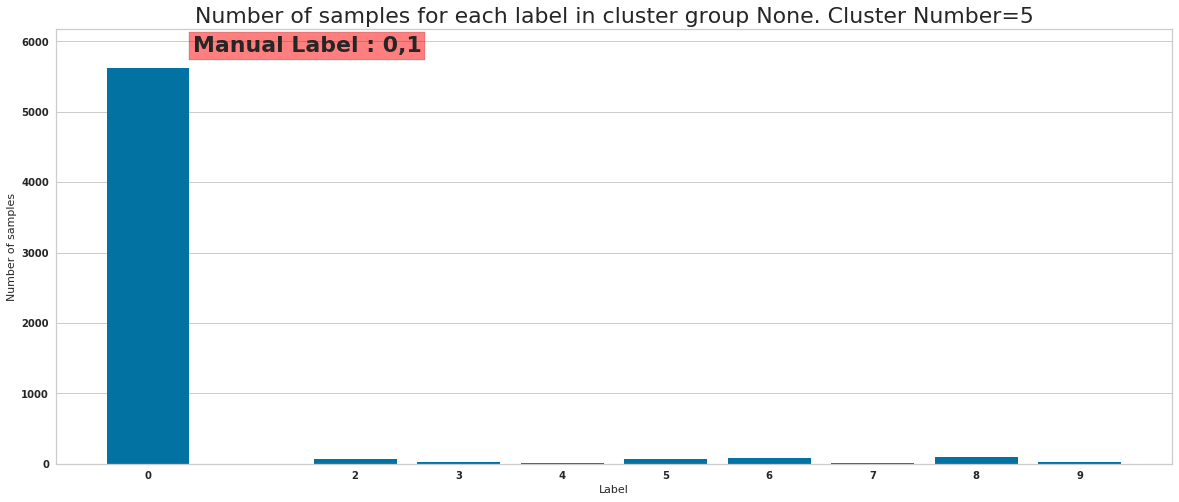

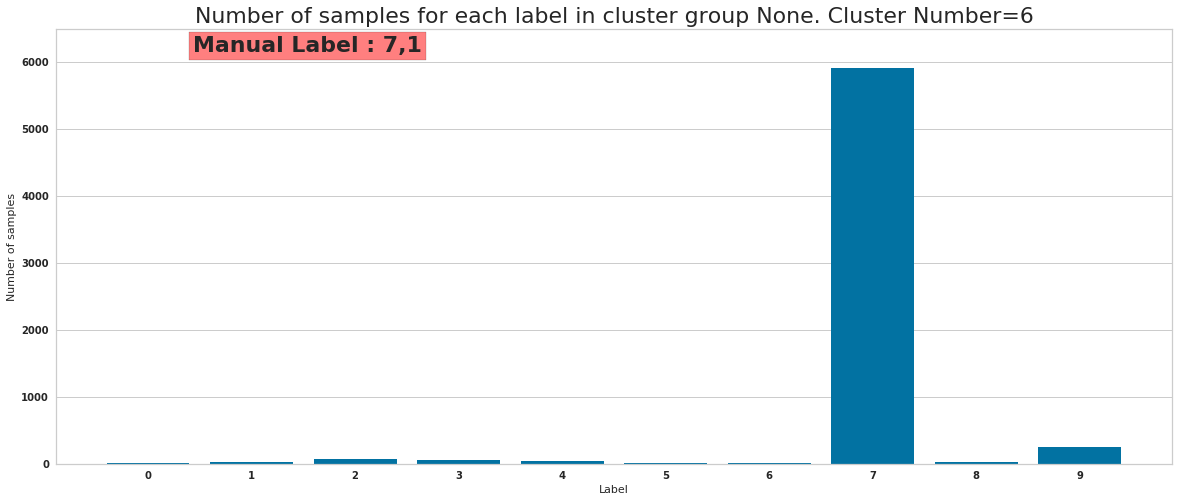

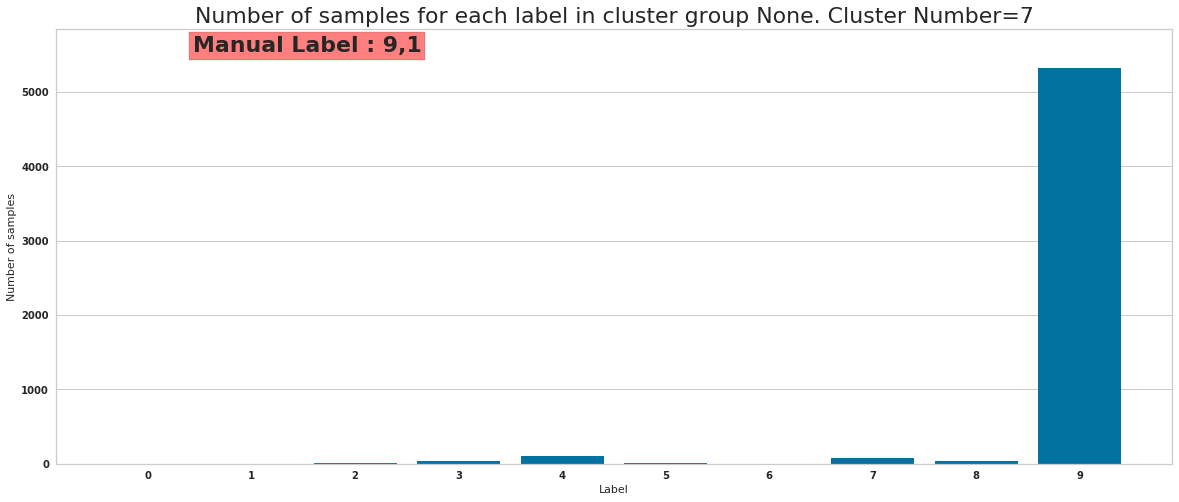

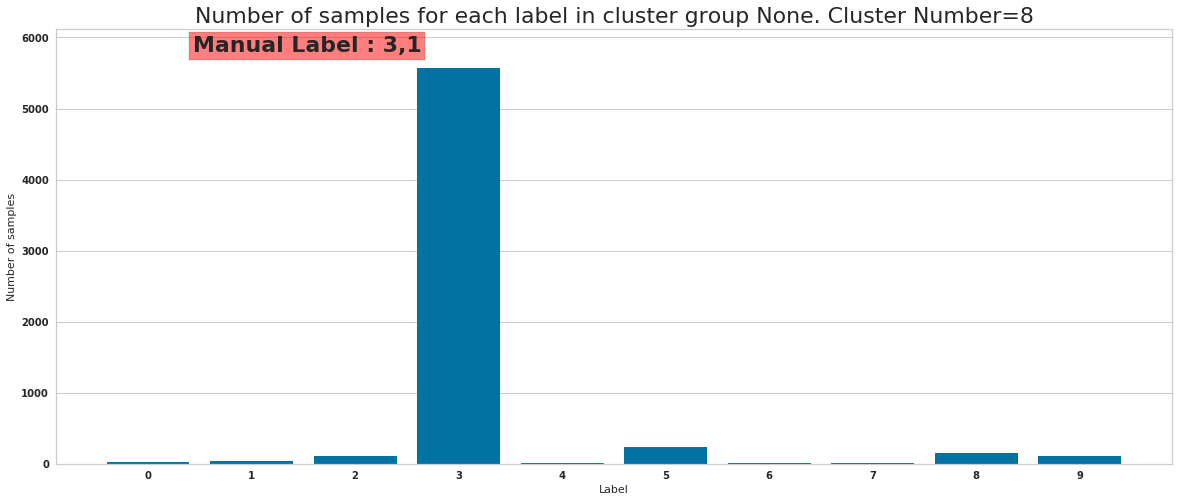

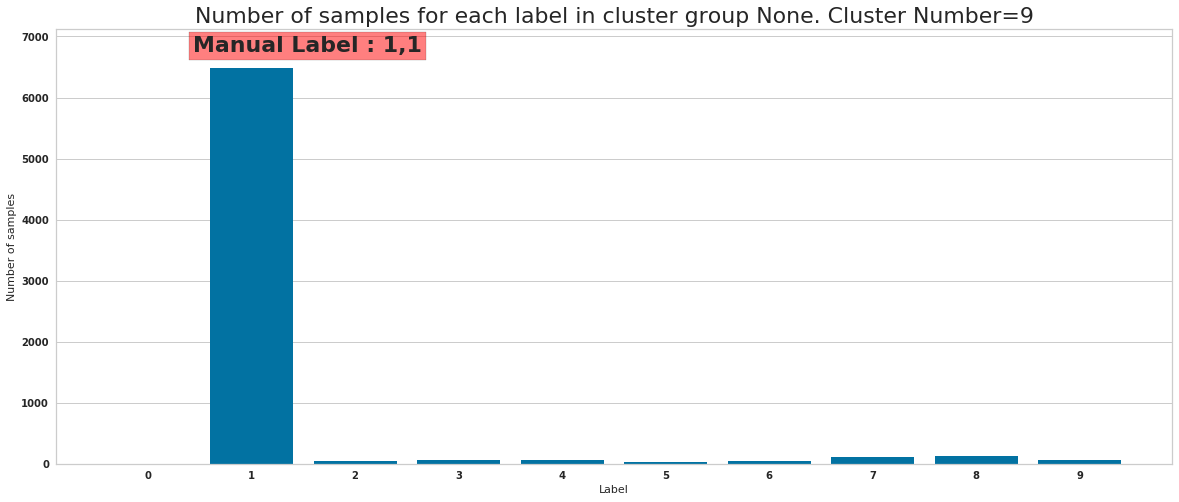

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 2, 8, 4,
                                           5, 0, 7, 9,
                                           3, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5924, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5943, 10)
(5857, 10)
(5675, 10)
(5161, 10)
(6008, 10)
(6401, 10)
(5585, 10)
(6265, 10)
(7021, 10)


In [ ]:
level2_manual_annotations =dict()

# TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [ ]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)    

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated=assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5924, 47) (5924, 33)
Num correct=5611
Cluster 0 Manual Label 6 Percentage correct 94.71640783254557
********************************
Manual Label 2
(5943, 47) (5943, 33)
Num correct=5354
Cluster 1 Manual Label 2 Percentage correct 90.0891805485445
********************************
Manual Label 8
(5857, 47) (5857, 33)
Num correct=5190
Cluster 2 Manual Label 8 Percentage correct 88.61191736383815
********************************
Manual Label 4
(5675, 47) (5675, 33)
Num correct=5480
Cluster 3 Manual Label 4 Percentage correct 96.56387665198238
********************************
Manual Label 5
(5161, 47) (5161, 33)
Num correct=4896
Cluster 4 Manual Label 5 Percentage correct 94.86533617515985
********************************
Manual Label 0
(6008, 47) (6008, 33)
Num correct=5615
Cluster 5 Manual Label 0 Percentage correct 93.45872170439414
********************************
Manual Label 7
(6401, 47) (6401, 33)
Num correct=5904
Cluster 6 Manual Label 7 Percentage correct 92.235588

In [ ]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)


Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6


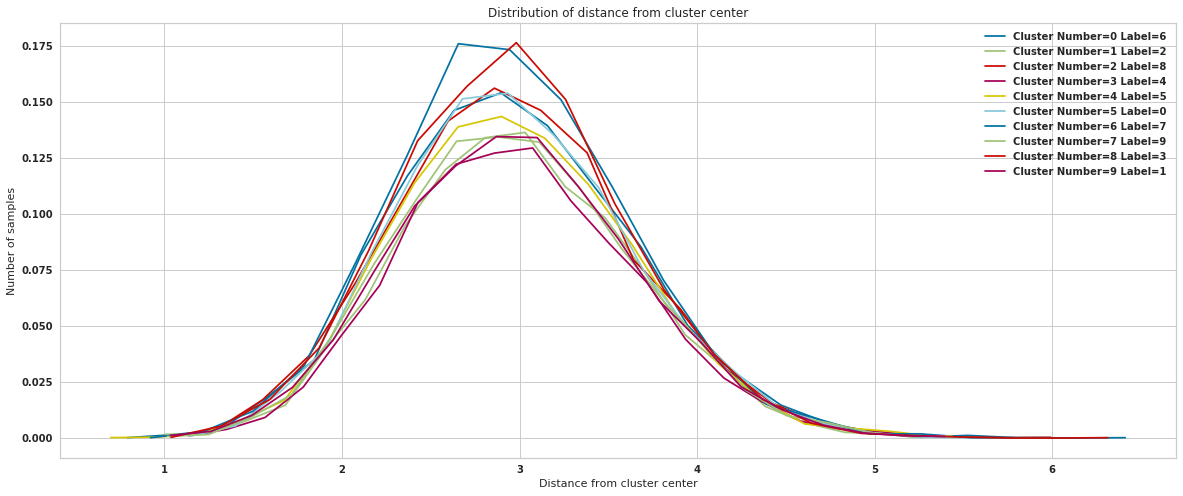

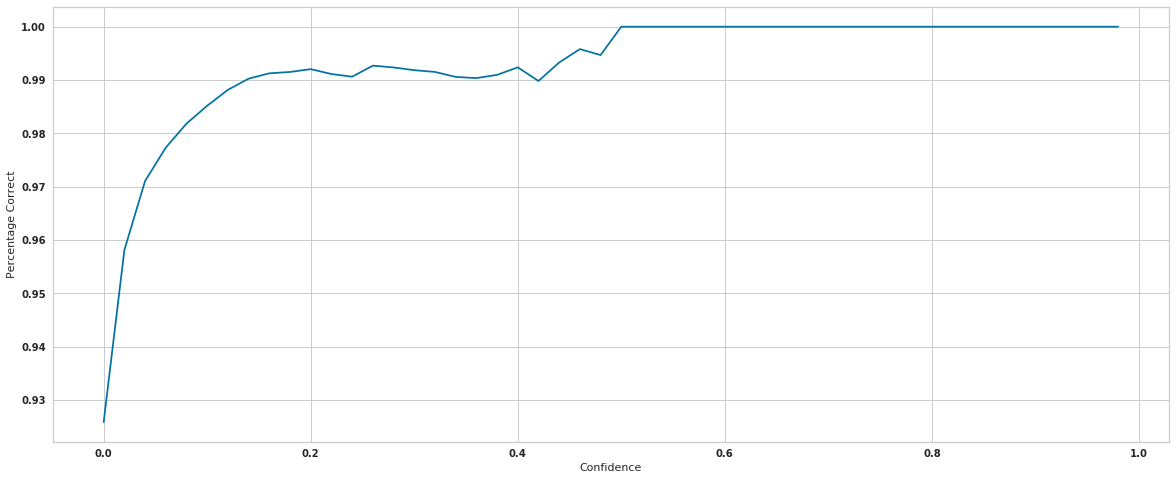

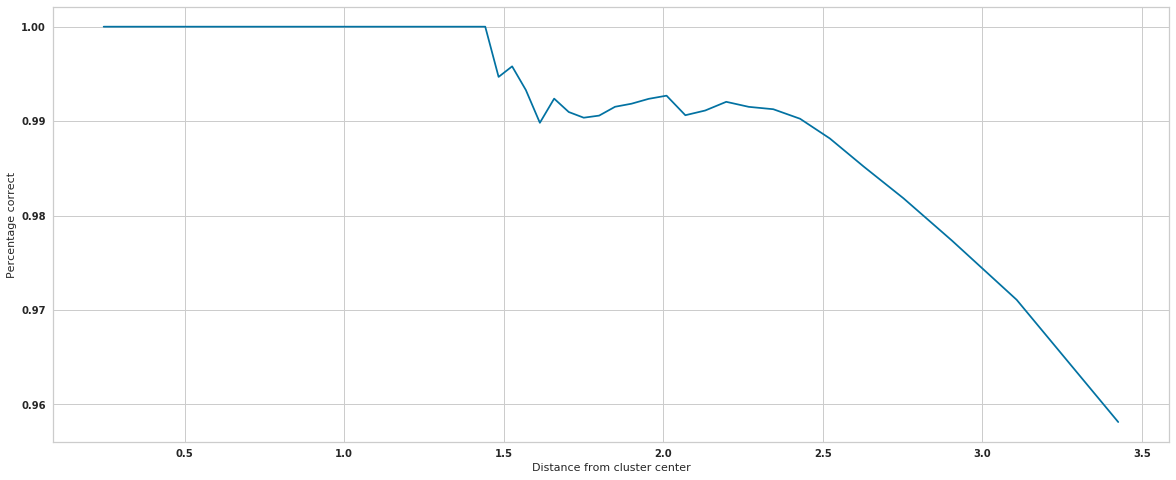

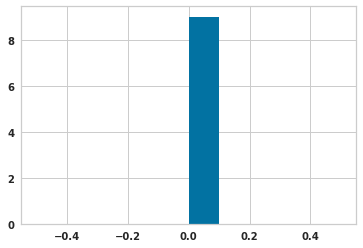

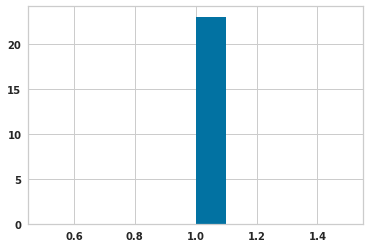

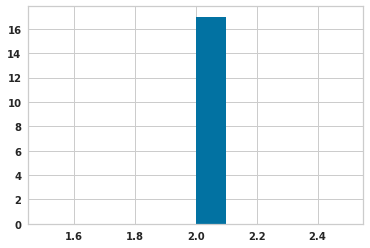

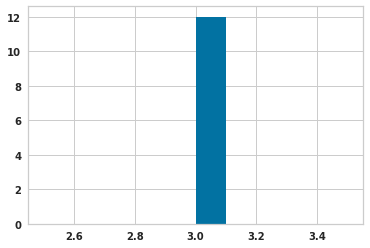

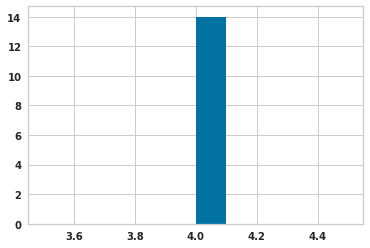

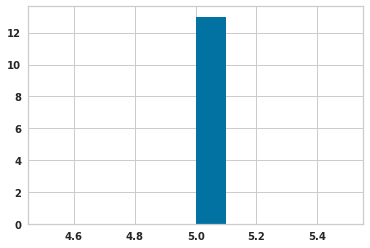

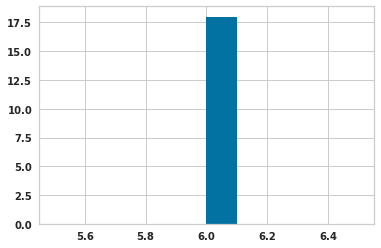

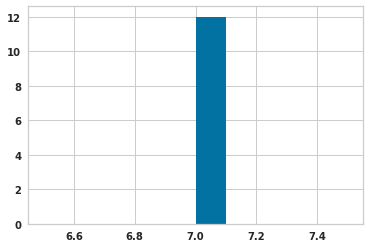

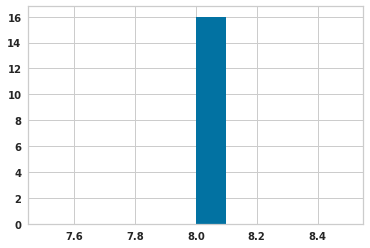

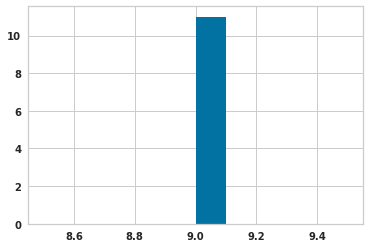

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)